## Reproducibility Note

This notebook was developed and executed in a Google Colab environment.
Some intermediate data objects (e.g. processed country–year dataframes) were created in-session and are not persisted in this repository due to data licensing restrictions.

As a result, not all cells will execute end-to-end without re-running the full data preparation pipeline or obtaining the source data locally.
All reported results and figures reflect the final executed state of the analysis.


## Data Construction and Coverage Diagnostics Pipeline

This script performs data preparation and coverage diagnostics for the V-Dem Country–Year dataset. It is intentionally broad and theory-agnostic, identifying a high-coverage indicator space prior to narrowing the analysis to institutional capture mechanisms.


In [ ]:
# ============================================================
# DEMOCRACY BACKSLIDING PIPELINE (V-Dem) — FULL SCRIPT
# Copy/paste into Google Colab and run top-to-bottom
# ============================================================
# What this script does:
# 1) Loads the V-Dem country-year dataset
# 2) Separates metadata columns from indicator columns
# 3) Standardizes missing values (V-Dem missing codes -> NaN)
# 4) Computes % missing ("gaps") for every indicator
# 5) Keeps only indicators with <=10% gaps
# 6) Builds two lists:
#    - predictors: plausible "conditions" before backsliding
#    - outcomes: indices/symptoms that are (often) backsliding itself
# 7) Keeps only point-estimate predictors (drops SD/bounds/expert components)
# 8) Creates 1-year lags within each country (no cross-country leakage)
# 9) Defines a simple backsliding outcome using change in v2x_polyarchy
# 10) Creates a modeling dataset that has all lagged predictors available
# 11) Saves key outputs to /content/
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# STEP 0: File path (edit if your file name/location differs)
# ------------------------------------------------------------
# In Colab, uploaded files typically live in /content/
file_path = "/content/V-Dem-CY-Full+Others-v15.csv"

# ------------------------------------------------------------
# STEP 1: Load data
# ------------------------------------------------------------
# low_memory=False avoids dtype guessing issues on large CSVs.
df_vdem = pd.read_csv(file_path, low_memory=False)

print("Loaded dataset.")
print("Shape (rows, columns):", df_vdem.shape)
# ------------------------------------------------------------
# STEP 1b: Restrict to contemporary sovereign states
# ------------------------------------------------------------
df_vdem = df_vdem.loc[
    (df_vdem["historical"] == 0) & (df_vdem["year"] >= 1990)
].copy()

print("Restricted to non-historical polities, post-1990.")
print("Remaining rows:", len(df_vdem))


# ------------------------------------------------------------
# STEP 2: Identify metadata vs indicators
# ------------------------------------------------------------
# Metadata columns identify the country and time.
# Everything else is treated as an indicator/tracker.
metadata_cols = [
    "country_name", "country_text_id", "country_id",
    "year", "historical_date", "project",
    "historical", "histname", "codingstart", "codingend"
]
metadata_cols = [c for c in metadata_cols if c in df_vdem.columns]

indicator_cols = [c for c in df_vdem.columns if c not in metadata_cols]

print("\nMetadata columns:", len(metadata_cols))
print("Indicator columns:", len(indicator_cols))

# ------------------------------------------------------------
# STEP 3: Standardize missing values
# ------------------------------------------------------------
# V-Dem commonly uses negative numeric codes for missingness.
# Converting them to NaN ensures missing calculations are correct.
missing_codes = [-99, -88, -77, -66]
df_vdem[indicator_cols] = df_vdem[indicator_cols].replace(missing_codes, np.nan)

# ------------------------------------------------------------
# STEP 4: Compute gap percentages for each indicator
# ------------------------------------------------------------
# Gap % = fraction of rows where the indicator is missing.
total_rows = len(df_vdem)

gap_table = pd.DataFrame({
    "v_dem_variable": indicator_cols,
    "missing_count": df_vdem[indicator_cols].isna().sum().values
})
gap_table["gap_percentage"] = (gap_table["missing_count"] / total_rows * 100).round(2)

print("\nComputed gap percentages for all indicators.")

# ------------------------------------------------------------
# STEP 5: Filter to low-gap indicators (<= 10% missing)
# ------------------------------------------------------------
# This creates a defensible “core” set with minimal missingness.
low_gap_vars = set(gap_table.loc[gap_table["gap_percentage"] <= 10, "v_dem_variable"])

print("Indicators with <=10% gaps:", len(low_gap_vars))

# ------------------------------------------------------------
# STEP 6: Split into predictors vs outcomes using transparent rules
# ------------------------------------------------------------
# Predictors = variables that plausibly exist before backsliding (conditions)
# Outcomes   = democracy indices or late-stage symptoms (part of backsliding)
#
# NOTE: This is a first-pass heuristic. You should manually review the final list.
predictor_keywords = [
    "el_",       # elections (admin/rules)
    "leg",       # legislature
    "jud",       # judiciary
    "court",
    "party",
    "military",
    "coup",
    "exec"
]

outcome_keywords = [
    "v2x_",      # V-Dem composite indices (often outcomes/targets)
    "v2cl_",     # civil liberties cluster (often outcomes)
    "censor",
    "harass",
    "arrest",
    "repress",
    "ban",
    "emergency",
    "torture",
    "kill"
]

predictor_candidates = [
    v for v in low_gap_vars
    if any(k in v for k in predictor_keywords)
    and not any(k in v for k in outcome_keywords)
]

outcome_candidates = [
    v for v in low_gap_vars
    if any(k in v for k in outcome_keywords)
]

print("\nInitial predictor candidates:", len(predictor_candidates))
print("Initial outcome candidates:", len(outcome_candidates))

# ------------------------------------------------------------
# STEP 7: Keep only point estimates (drop SD/bounds/expert components)
# ------------------------------------------------------------
# V-Dem provides multiple versions of a concept:
# - point estimate
# - uncertainty (sd)
# - bounds (codehigh/codelow)
# - expert components (e_...)
#
# For standard modeling, keep one column per concept (point estimate).
predictors_clean = sorted([
    v for v in predictor_candidates
    if not (
        v.endswith("_sd")
        or "codehigh" in v
        or "codelow" in v
        or v.startswith("e_")
    )
])

outcomes_clean = sorted(outcome_candidates)

print("\nFinal predictors (point estimates):", len(predictors_clean))
print("Outcomes identified:", len(outcomes_clean))

# ------------------------------------------------------------
# STEP 8: Sort by country and year before creating lags
# ------------------------------------------------------------
# Sorting ensures that year t-1 really comes right before year t within each country.
df_vdem = df_vdem.sort_values(["country_id", "year"])

# ------------------------------------------------------------
# STEP 9: Create 1-year lags for predictors (within each country)
# ------------------------------------------------------------
# This is the key step for temporal logic:
# - groupby(country_id) ensures lags are computed country-by-country
# - shift(1) assigns last year's value to the current year
#
# IMPORTANT: This prevents any cross-country leakage.
for var in predictors_clean:
    df_vdem[f"{var}_lag1"] = df_vdem.groupby("country_id")[var].shift(1)

print("\nLagged predictors created (t-1) within each country.")

# ------------------------------------------------------------
# STEP 10: Define democratic backsliding outcome
# ------------------------------------------------------------
# Backsliding = substantive decline in polyarchy (≤ -0.01)
df_vdem["polyarchy_change"] = (
    df_vdem.groupby("country_id")["v2x_polyarchy"].diff()
)

df_vdem["backsliding"] = (df_vdem["polyarchy_change"] <= -0.01).astype(int)

# ------------------------------------------------------------
# STEP 11: Create the modeling dataset (drop rows without lagged predictors)
# ------------------------------------------------------------
# The first observed year for each country has no lagged predictors by definition.
# Those rows cannot be used in lagged models, so we drop ONLY those rows.
lag_cols = [f"{v}_lag1" for v in predictors_clean]

model_df = df_vdem.dropna(subset=lag_cols)

print("\nModeling dataset created.")
print("Original rows:", len(df_vdem))
print("Rows usable for lagged models:", len(model_df))

# ------------------------------------------------------------
# STEP 13: Optional gap brackets summary (0–10%, 10–30%, 30–60%, 60–100%)
# ------------------------------------------------------------
# This provides a simple report of how many indicators fall into each gap range.
gap_bins = [0, 10, 30, 60, 100]
gap_labels = ["0–10% gaps", "10–30% gaps", "30–60% gaps", "60–100% gaps"]

gap_table["gap_bracket"] = pd.cut(
    gap_table["gap_percentage"],
    bins=gap_bins,
    labels=gap_labels,
    include_lowest=True,
    right=True
)

gap_summary = (
    gap_table["gap_bracket"]
    .value_counts()
    .sort_index()
    .reset_index()
)
gap_summary.columns = ["gap_percentage_bracket", "number_of_indicators"]

print("\nGap bracket summary (all indicators):")
print(gap_summary)

# ------------------------------------------------------------
# STEP 14: Save outputs to /content/
# ------------------------------------------------------------
# These files help you reproduce and document your workflow.
#gap_table.to_csv("/content/vdem_gap_table.csv", index=False)
#gap_summary.to_csv("/content/vdem_gap_bracket_summary.csv", index=False)
#pd.DataFrame({"predictor": predictors_clean}).to_csv("/content/vdem_predictors_final.csv", index=False)
#pd.DataFrame({"outcome_indicator": outcomes_clean}).to_csv("/content/vdem_outcomes_final.csv", index=False)
#model_df.to_csv("/content/vdem_model_dataset.csv", index=False)

print("\nPipeline complete. Files saved to /content/:")
print("- vdem_gap_table.csv")
print("- vdem_gap_bracket_summary.csv")
print("- vdem_predictors_final.csv")
print("- vdem_outcomes_final.csv")
print("- vdem_model_dataset.csv")


Loaded dataset.
Shape (rows, columns): (27913, 4607)
Restricted to non-historical polities, post-1990.
Remaining rows: 3727

Metadata columns: 10
Indicator columns: 4597


/tmp/ipython-input-213854809.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_vdem[indicator_cols] = df_vdem[indicator_cols].replace(missing_codes, np.nan)



Computed gap percentages for all indicators.
Indicators with <=10% gaps: 2633

Initial predictor candidates: 114
Initial outcome candidates: 269

Final predictors (point estimates): 43
Outcomes identified: 269

Lagged predictors created (t-1) within each country.

Modeling dataset created.
Original rows: 3727
Rows usable for lagged models: 3292

Gap bracket summary (all indicators):
  gap_percentage_bracket  number_of_indicators
0             0–10% gaps                  2633
1            10–30% gaps                  1102
2            30–60% gaps                   168
3           60–100% gaps                   694

Pipeline complete. Files saved to /content/:
- vdem_gap_table.csv
- vdem_gap_bracket_summary.csv
- vdem_predictors_final.csv
- vdem_outcomes_final.csv
- vdem_model_dataset.csv


## How to Read the Results

## Data Construction and Coverage Diagnostics

This pipeline prepares the V-Dem Country–Year dataset for analysis and evaluates which institutional indicators can be used without sacrificing cross-national comparability. The analysis is restricted to non-historical polities observed since 1990, yielding a contemporary sample of 3,727 country–year observations.

### Indicator Coverage

V-Dem includes a very large number of indicators with varying degrees of missingness across countries and time. To assess what kinds of analyses are feasible, missing-data coverage is calculated for all indicators after standardizing V-Dem missing-value codes.

The coverage diagnostics show that:
- Approximately **2,633 indicators** have **10% or less missing data**, allowing for broad cross-national analysis.
- A substantial number of indicators exhibit moderate to high missingness, making them unsuitable for global panel models without imputation or casewise deletion.

This confirms that requiring complete data for many indicators would sharply reduce the usable sample.

### Predictor and Outcome Identification

Using transparent heuristic rules, indicators are provisionally classified into:
- **Predictor candidates**, representing institutional conditions that plausibly precede democratic backsliding (e.g., legislative oversight, electoral rules, party systems).
- **Outcome candidates**, representing composite democracy indices or late-stage symptoms of democratic erosion.

After excluding uncertainty measures, bounds, and expert-level components, the final predictor set consists of **43 point-estimate institutional indicators** with high coverage.

### Lagged Design and Modeling Sample

All predictors are lagged by one year within countries to ensure temporal ordering and to avoid simultaneity. Because lagged models cannot use the first observed year for each country, the final modeling dataset contains **3,292 country–year observations**.

Overall, these diagnostics demonstrate that meaningful early-warning analyses of democratic backsliding can be conducted using a high-coverage subset of institutional indicators, without relying on imputation or sacrificing global scope.

### Handling of Missing Values

V-Dem uses multiple negative numeric codes to represent different forms of missing data. These values are standardized to `NaN` prior to analysis to ensure that missingness is treated consistently.

Rather than imputing missing values or relying on casewise deletion across a large number of indicators, the analysis adopts a coverage-based approach. Indicators with high levels of missingness are excluded from the predictor pool, and models are estimated only on country–year observations with observed values for the selected lagged predictors. As a result, missing data primarily affect the inclusion of indicators rather than the exclusion of countries.



##Baseline Coefficient Visual

The below baseline model includes a large number of institutional indicators and alternative operationalisations. For clarity, this figure visualises one representative indicator per core institutional concept. The full coefficient table is reported above and is used to motivate a narrower, theory-driven institutional capture model.*


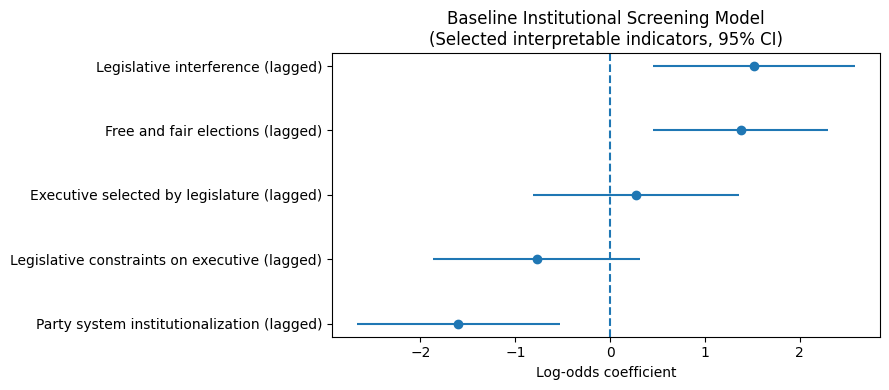

In [ ]:
# ============================================================
# BASELINE COEFFICIENT VISUAL
# One representative indicator per core institutional concept
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Explicit list of interpretable baseline indicators
#    (ONE per conceptual family)
# ------------------------------------------------------------
baseline_visual_vars = [
    "v2xlg_leginter_lag1",   # Legislative interference
    "v2xlg_legcon_lag1",     # Legislative constraints on executive
    "v2xex_elecleg_lag1",    # Executive selected by legislature
    "v2xps_party_lag1",      # Party system institutionalization
    "v2xel_frefair_lag1",    # Free and fair elections
]

# ------------------------------------------------------------
# 2. Authoritative human-readable labels
# ------------------------------------------------------------
baseline_labels = {
    "v2xlg_leginter_lag1": "Legislative interference (lagged)",
    "v2xlg_legcon_lag1": "Legislative constraints on executive (lagged)",
    "v2xex_elecleg_lag1": "Executive selected by legislature (lagged)",
    "v2xps_party_lag1": "Party system institutionalization (lagged)",
    "v2xel_frefair_lag1": "Free and fair elections (lagged)",
}

# ------------------------------------------------------------
# 3. Build coefficient table from fitted model
# ------------------------------------------------------------
coef_df = pd.DataFrame({
    "coef": baseline_results.params,
    "lower": baseline_results.conf_int()[0],
    "upper": baseline_results.conf_int()[1],
})

# Keep only selected interpretable indicators
coef_df = coef_df.loc[coef_df.index.isin(baseline_visual_vars)]

# Add readable labels
coef_df["label"] = coef_df.index.map(baseline_labels)

# Sort for readability
coef_df = coef_df.sort_values("coef")

# ------------------------------------------------------------
# 4. Auto-scaled plot (height adjusts to number of variables)
# ------------------------------------------------------------
fig_height = max(4, 0.7 * coef_df.shape[0])

plt.figure(figsize=(9, fig_height))
plt.errorbar(
    coef_df["coef"],
    coef_df["label"],
    xerr=[
        coef_df["coef"] - coef_df["lower"],
        coef_df["upper"] - coef_df["coef"]
    ],
    fmt="o"
)

plt.axvline(0, linestyle="--")
plt.xlabel("Log-odds coefficient")
plt.ylabel("")
plt.title(
    "Baseline Institutional Screening Model\n"
    "(Selected interpretable indicators, 95% CI)"
)

plt.tight_layout()
plt.show()


## How to Read the Results

## Baseline Institutional Screening Model

The baseline institutional screening model provides an initial, broad assessment of which institutional features tend to change prior to democratic backsliding. Rather than testing a single theory, this model includes a wide range of institutional indicators to identify general patterns and potential early warning signals.

This model should be understood as diagnostic rather than causal. Its purpose is to screen across many institutional dimensions—such as legislative oversight, party competition, electoral rules, and political inclusion—and to highlight where the strongest associations with subsequent democratic decline appear.

### How to Read the Coefficient Plot

In the coefficient plot, each point represents the estimated association between a lagged institutional indicator and the probability of democratic backsliding in the following year.

- Points to the **right of zero** indicate institutional conditions associated with a higher likelihood of backsliding.
- Points to the **left of zero** indicate conditions associated with a lower likelihood of backsliding (protective factors).
- Horizontal lines show **95% confidence intervals**. When an interval crosses zero, the association is less precisely estimated.

Importantly, the direction (left or right) does not indicate importance by itself. Instead, the plot is used to identify which institutional domains consistently exhibit signal in a broad specification.

### Role in the Overall Analysis

The baseline screening model is not the main result of the analysis. Instead, it motivates the narrower, theory-driven institutional capture model presented in the next section. The similarity between the baseline patterns and the capture-focused results indicates that elite-driven institutional interference and rule manipulation account for much of the signal detected in the broader screening exercise.


## Core Institutional Predictor Set

Based on coverage diagnostics and theoretical relevance, this analysis focuses on a core set of high-coverage institutional indicators capturing electoral rules, legislative oversight, political inclusion, and information environments. All predictors are lagged by one year to ensure temporal ordering.


In [ ]:
# ------------------------------------------------------------
# Core institutional predictors (high-coverage, interpretable)
# ------------------------------------------------------------
core_inst_vars = [

    "v2asuffrage_lag1",
    "v2xps_party_lag1",
    "v2xnp_client_lag1",
    "v2xme_altinf_lag1",
    "v2xlg_legcon_lag1",
    "v2xlg_leginter_lag1",
    "v2xlg_elecreg_lag1",
    "v2xex_elecreg_lag1",
    "v2xex_elecleg_lag1",
    "v2xpe_exlpol_lag1",
    "v2xpe_exlsocgr_lag1",
    "v2xpe_exlgeo_lag1"
]


In [ ]:
# ------------------------------------------------------------
# Base institutional indicators (unlagged; used for lag creation)
# ------------------------------------------------------------
base_inst_vars =
    "v2asuffrage",
    "v2xps_party",
    "v2xnp_client",
    "v2xme_altinf",
    "v2xlg_legcon",
    "v2xlg_leginter",
    "v2xlg_elecreg",
    "v2xex_elecreg",
    "v2xex_elecleg",
    "v2xpe_exlpol",
    "v2xpe_exlsocgr",
    "v2xpe_exlgeo"
]


### Diagnostic Institutional Screening Model

This code block estimates a diagnostic screening model to identify institutional features that systematically precede democratic backsliding. Using a country–year panel, the model predicts the probability of backsliding in year *t* as a function of a broad set of institutional conditions measured in year *t−1*.

A wide range of institutional indicators is included to avoid ex ante exclusion of potentially relevant predictors. All variables are lagged by one year within countries to ensure temporal ordering and reduce simultaneity. Observations with missing lagged values are removed to construct a valid design matrix.

The model is estimated using logistic regression with standard errors clustered by country to account for serial correlation in the panel data. This screening specification is used to establish the direction and relative strength of associations across institutional domains. Results from this model inform the selection of a smaller, more interpretable baseline specification presented later.




                           Logit Regression Results                           
Dep. Variable:            backsliding   No. Observations:                14293
Model:                          Logit   Df Residuals:                    14280
Method:                           MLE   Df Model:                           12
Date:                Sat, 03 Jan 2026   Pseudo R-squ.:                 0.04761
Time:                        17:22:52   Log-Likelihood:                -8144.2
converged:                       True   LL-Null:                       -8551.3
Covariance Type:              cluster   LLR p-value:                1.498e-166
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -2.9476      0.275    -10.704      0.000      -3.487      -2.408
Universa

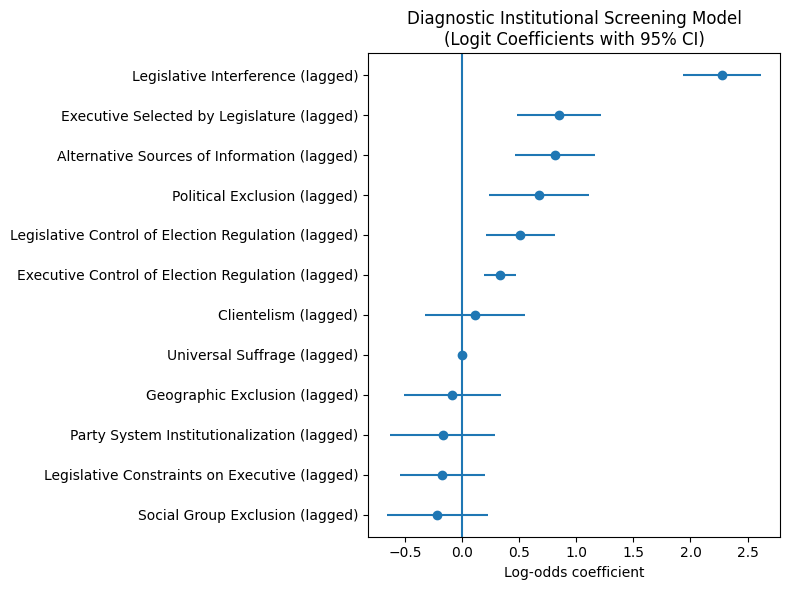

In [ ]:
# ============================================================
# 0. Imports
# ============================================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


# ============================================================
# 1. Ensure model_df is a proper copy (avoid SettingWithCopyWarning)
# ============================================================
model_df = model_df.copy()


# ============================================================
# 2. Base institutional variables (unlagged)
# ============================================================
base_vars = [
    "v2asuffrage",
    "v2xps_party",
    "v2xnp_client",
    "v2xme_altinf",
    "v2xlg_legcon",
    "v2xlg_leginter",
    "v2xlg_elecreg",
    "v2xex_elecreg",
    "v2xex_elecleg",
    "v2xpe_exlpol",
    "v2xpe_exlsocgr",
    "v2xpe_exlgeo"
]


# ============================================================
# 3. Create 1-year lags by country
# ============================================================
model_df = model_df.sort_values(["country_id", "year"])

for var in base_vars:
    model_df[f"{var}_lag1"] = (
        model_df
        .groupby("country_id")[var]
        .shift(1)
    )


# ============================================================
# 4. Lagged predictor list (explicit and auditable)
# ============================================================
lag_vars = [
    "v2asuffrage_lag1",
    "v2xps_party_lag1",
    "v2xnp_client_lag1",
    "v2xme_altinf_lag1",
    "v2xlg_legcon_lag1",
    "v2xlg_leginter_lag1",
    "v2xlg_elecreg_lag1",
    "v2xex_elecreg_lag1",
    "v2xex_elecleg_lag1",
    "v2xpe_exlpol_lag1",
    "v2xpe_exlsocgr_lag1",
    "v2xpe_exlgeo_lag1"
]


# ============================================================
# 5. Drop rows with missing lagged values (required)
# ============================================================
model_df_model = (
    model_df
    .dropna(subset=lag_vars + ["backsliding"])
    .copy()
)


# ============================================================
# 6. Outcome and design matrix
# ============================================================
y = model_df_model["backsliding"]

X = sm.add_constant(
    model_df_model[lag_vars].astype(float)
)


# ============================================================
# 7. Variable labels
# ============================================================
variable_labels = {
    "const": "Intercept",
    "v2asuffrage_lag1": "Universal Suffrage (lagged)",
    "v2xps_party_lag1": "Party System Institutionalization (lagged)",
    "v2xnp_client_lag1": "Clientelism (lagged)",
    "v2xme_altinf_lag1": "Alternative Sources of Information (lagged)",
    "v2xlg_legcon_lag1": "Legislative Constraints on Executive (lagged)",
    "v2xlg_leginter_lag1": "Legislative Interference (lagged)",
    "v2xlg_elecreg_lag1": "Legislative Control of Election Regulation (lagged)",
    "v2xex_elecreg_lag1": "Executive Control of Election Regulation (lagged)",
    "v2xex_elecleg_lag1": "Executive Selected by Legislature (lagged)",
    "v2xpe_exlpol_lag1": "Political Exclusion (lagged)",
    "v2xpe_exlsocgr_lag1": "Social Group Exclusion (lagged)",
    "v2xpe_exlgeo_lag1": "Geographic Exclusion (lagged)"
}

X = X.rename(columns=variable_labels)


# ============================================================
# 8. Fit logistic regression with country-clustered SEs
# ============================================================
logit_model = sm.Logit(y, X)

logit_results = logit_model.fit(
    disp=False,
    cov_type="cluster",
    cov_kwds={"groups": model_df_model["country_id"]}
)

print(logit_results.summary())


# ============================================================
# 9. Diagnostic coefficient plot (NOT main results)
# ============================================================
coef_df = pd.DataFrame({
    "coef": logit_results.params,
    "lower": logit_results.conf_int()[0],
    "upper": logit_results.conf_int()[1]
})

coef_df = coef_df.drop("Intercept", errors="ignore")
coef_df = coef_df.sort_values("coef")

plt.figure(figsize=(8, 6))
plt.errorbar(
    coef_df["coef"],
    coef_df.index,
    xerr=[
        coef_df["coef"] - coef_df["lower"],
        coef_df["upper"] - coef_df["coef"]
    ],
    fmt="o"
)

plt.axvline(0)
plt.title("Diagnostic Institutional Screening Model\n(Logit Coefficients with 95% CI)")
plt.xlabel("Log-odds coefficient")
plt.ylabel("")
plt.tight_layout()
plt.show()


### Interpretation of Diagnostic Institutional Screening Results

The table and accompanying coefficient plot summarise results from a diagnostic logistic regression predicting democratic backsliding. Coefficients are reported in log-odds units with 95% confidence intervals, and all institutional predictors are lagged by one year. Positive coefficients indicate a higher probability of subsequent backsliding, while negative coefficients indicate a protective association.

Several variables emerge as strong and substantively meaningful predictors. **Legislative Interference (lagged)** has the largest positive coefficient and is precisely estimated, indicating that erosion of legislative autonomy is a powerful early warning signal of democratic decline. **Legislative Control of Election Regulation (lagged)** and **Executive Control of Election Regulation (lagged)** are also positively associated with backsliding, consistent with theories emphasising manipulation of electoral rules as a gradual strategy of democratic erosion. **Executive Selected by Legislature (lagged)** similarly increases backsliding risk, suggesting weakened separation of powers.

Forms of political exclusion are also relevant. **Political Exclusion (lagged)** shows a positive and statistically significant association with backsliding, indicating that narrowing the political arena precedes democratic decline. In contrast, **Social Group Exclusion (lagged)** and **Geographic Exclusion (lagged)** do not display clear short-term effects in this specification.

Notably, **Alternative Sources of Information (lagged)** is positively associated with backsliding. This result suggests that the presence of multiple information sources does not necessarily ensure accountability and may reflect underlying polarisation or institutional stress rather than democratic resilience.

Several slow-moving or structural variables show weak or null associations. **Party System Institutionalization (lagged)**, **Clientelism (lagged)**, **Universal Suffrage (lagged)**, and **Legislative Constraints on Executive (lagged)** do not reach conventional significance levels. These null findings are substantively informative, indicating that democratic backsliding is less about abrupt changes in mass inclusion or long-run structural features, and more about institutional interference, rule manipulation, and political exclusion.

The coefficient plot complements the regression table by visualising the relative magnitude and uncertainty of estimates. Together, the table and figure are used as a diagnostic screening exercise to identify institutional warning signals and to motivate more focused baseline and capture-index models, rather than to make precise probabilistic predictions.


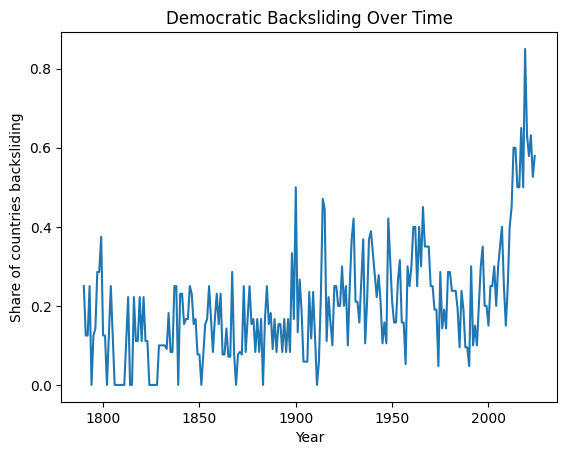

In [ ]:
# ============================================================
# VISUALIZATION : Backsliding over time
# ============================================================

backsliding_by_year = (
    model_df.groupby("year")["backsliding"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(backsliding_by_year["year"],
         backsliding_by_year["backsliding"])
plt.ylabel("Share of countries backsliding")
plt.xlabel("Year")
plt.title("Democratic Backsliding Over Time")
plt.show()

### Methodology: Democratic Backsliding Over Time

This figure shows the annual share of countries experiencing democratic backsliding, where backsliding is defined as a year-to-year decline in the V-Dem polyarchy index within a country. For each year, the numerator is the number of countries classified as backsliding in that year, and the denominator is the number of countries observed in the dataset for that year.

The measure is constructed using country–year data and reflects within-country changes over time rather than cross-sectional differences between countries. Because the number of countries in the international system varies historically, the figure reports shares rather than raw counts.

This time series is descriptive and intended to provide contextual background on long-run patterns in democratic erosion. It does not account for country-specific characteristics, institutional covariates, or global shocks, which are addressed in the regression analyses that follow.

The number of countries contributing to the estimate varies over time. In the contemporary period (post-1990), the figure is based on approximately 108 sovereign states, corresponding to roughly 3,700 country–year observations used in the main analysis.


In [ ]:
# ------------------------------------------------------------
# STEP 4: Identify substantive indicators (drop bounds/SDs)
# ------------------------------------------------------------
metadata_cols = [
    "country_name", "country_text_id", "country_id",
    "year", "historical_date", "project",
    "historical", "histname", "codingstart", "codingend"
]

indicator_cols = [c for c in df.columns if c not in metadata_cols]

substantive_indicators = [
    c for c in indicator_cols
    if not (
        c.endswith("_sd")
        or "codehigh" in c
        or "codelow" in c
        or c.startswith("e_")
    )
]



Substantive indicators: 2083


### Substantive Indicator Selection

V-Dem provides multiple columns for many concepts, including uncertainty estimates, upper and lower bounds, and expert-level components. To ensure interpretability and avoid duplicating the same concept in different forms, the analysis retains only substantive point-estimate indicators. Measures representing uncertainty, bounds, or disaggregated expert inputs are excluded at this stage.


In [ ]:
# ============================================================
# V-Dem Backsliding Analysis — FULL PIPELINE (CLEAN VERSION)
# ============================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm

# ============================================================
# 1. LOAD DATA (HARD RESET)
# ============================================================

df = pd.read_csv(
    "/content/V-Dem-CY-Full+Others-v15.csv",
    low_memory=False
)

# Standardize V-Dem missing codes
missing_codes = [-99, -88, -77, -66]
df.replace(missing_codes, np.nan, inplace=True)

print("Total countries in raw data:", df["country_name"].nunique())
print("Total rows:", len(df))

# ============================================================
# 2. DEFINE COUNTRIES THAT EXIST TODAY
# ============================================================

countries_today = (
    df.loc[
        (df["historical"] == 0) & (df["year"] >= 2000),
        ["country_id", "country_name"]
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)

n_countries_today = len(countries_today)
print("Countries existing today:", n_countries_today)

# Restrict dataset
df = df[df["country_id"].isin(countries_today["country_id"])].copy()

# ============================================================
# 3. RESTRICT TO MODERN PERIOD
# ============================================================

df = df[df["year"] >= 1990].copy()

print("Countries in modern sample:", df["country_name"].nunique())
print("Years:", df["year"].min(), "to", df["year"].max())

# ============================================================
# 4. DEFINE BACKSLIDING OUTCOME
# ============================================================

df = df.sort_values(["country_id", "year"])

df["polyarchy_change"] = (
    df.groupby("country_id")["v2x_polyarchy"].diff()
)

BACKSLIDE_THRESHOLD = -0.01
df["backsliding"] = (df["polyarchy_change"] <= BACKSLIDE_THRESHOLD).astype(int)

print("Overall backsliding rate:", round(df["backsliding"].mean(), 3))

# ============================================================
# 5. IDENTIFY SUBSTANTIVE INDICATORS (FOR COVERAGE)
# ============================================================

metadata_cols = [
    "country_name", "country_text_id", "country_id",
    "year", "historical_date", "project",
    "historical", "histname", "codingstart", "codingend"
]

indicator_cols = [c for c in df.columns if c not in metadata_cols]

substantive_indicators = [
    c for c in indicator_cols
    if not (
        c.endswith("_sd")
        or "codehigh" in c
        or "codelow" in c
        or c.startswith("e_")
    )
]

print("Substantive indicators:", len(substantive_indicators))

# ============================================================
# 6. INDICATOR COVERAGE ACROSS COUNTRIES
# ============================================================

presence_records = []

for ind in substantive_indicators:
    temp = (
        df[["country_id", ind]]
        .dropna(subset=[ind])
        .drop_duplicates(subset=["country_id"])
        .assign(present=1)
        [["country_id", "present"]]
    )
    temp["indicator"] = ind
    presence_records.append(temp)

presence_df = pd.concat(presence_records, ignore_index=True)

presence_today = presence_df.merge(
    countries_today,
    on="country_id",
    how="inner"
)

indicator_coverage = (
    presence_today
    .groupby("indicator")["country_id"]
    .nunique()
    .reset_index(name="n_countries")
)

indicator_coverage["share_of_countries"] = (
    indicator_coverage["n_countries"] / n_countries_today
).round(3)

indicator_coverage = indicator_coverage.sort_values(
    "share_of_countries", ascending=False
)

# ============================================================
# 7. ADD HUMAN-READABLE INDICATOR NAMES
# ============================================================

indicator_labels = {
    "v2asuffrage": "Universal Suffrage",
    "v2xps_party": "Party System Institutionalization",
    "v2xnp_client": "Clientelism",
    "v2xme_altinf": "Alternative Sources of Information",
    "v2xlg_legcon": "Legislative Constraints on Executive",
    "v2xlg_leginter": "Legislative Interference",
    "v2xlg_elecreg": "Legislative Control of Election Regulation",
    "v2xex_elecreg": "Executive Control of Election Regulation",
    "v2xex_elecleg": "Executive Selected by Legislature",
    "v2xpe_exlpol": "Political Exclusion",
    "v2xpe_exlsocgr": "Social Group Exclusion",
    "v2xpe_exlgeo": "Geographic Exclusion"
}

indicator_coverage["attribute_name"] = (
    indicator_coverage["indicator"]
    .map(indicator_labels)
    .fillna(indicator_coverage["indicator"])
)

indicator_coverage = indicator_coverage[
    ["indicator", "attribute_name", "n_countries", "share_of_countries"]
]


display(indicator_coverage.head(15))

# ============================================================
# 8. DEFINE CORE PREDICTORS (100% COVERAGE SET)
# ============================================================

core_predictors = list(indicator_labels.keys())


Total countries in raw data: 202
Total rows: 27913
Countries existing today: 108
Countries in modern sample: 108
Years: 1990 to 2024
Overall backsliding rate: 0.148
Substantive indicators: 2085

Top indicators by coverage:


,indicator,attribute_name,n_countries,share_of_countries
1757,v2xps_party,Party System Institutionalization,108,1.0
1756,v2xpe_exlsocgr,Social Group Exclusion,108,1.0
1,backsliding,backsliding,108,1.0
2,codingend_contemp,codingend_contemp,108,1.0
3,codingstart_contemp,codingstart_contemp,108,1.0
4,gap_index,gap_index,108,1.0
1755,v2xpe_exlpol,Political Exclusion,108,1.0
1754,v2xpe_exlgeo,Geographic Exclusion,108,1.0
7,polyarchy_change,polyarchy_change,108,1.0
8,v2asuffrage,Universal Suffrage,108,1.0


### Sample Construction and Scope

The raw V-Dem Country–Year dataset contains 202 political units and 27,913 observations. The analysis is restricted to contemporary sovereign states, yielding a final sample of 108 countries observed between 1990 and 2024.

Democratic backsliding is defined as a year-to-year decline in the V-Dem polyarchy index. In the modern sample, backsliding occurs in approximately 15 percent of country–year observations, consistent with the episodic and gradual nature of democratic erosion.

To ensure interpretability and comparability, the analysis retains only substantive point-estimate indicators. After excluding uncertainty measures, bounds, and expert-level components, the dataset contains just over 2,000 substantive institutional indicators. A large subset of these indicators—including measures of party system institutionalization, political exclusion, legislative interference, and electoral regulation—exhibits full coverage across all 108 countries.


In [ ]:
# ------------------------------------------------------------
# Core institutional indicators (100% coverage; canonical set)
# ------------------------------------------------------------
core_inst_vars = [
    "v2asuffrage",
    "v2xps_party",
    "v2xnp_client",
    "v2xme_altinf",
    "v2xlg_legcon",
    "v2xlg_leginter",
    "v2xlg_elecreg",
    "v2xex_elecreg",
    "v2xex_elecleg",
    "v2xpe_exlpol",
    "v2xpe_exlsocgr",
    "v2xpe_exlgeo"
]


### Core Institutional Predictor Set

Based on the coverage diagnostics, the analysis defines a fixed set of core institutional indicators that are observed for all contemporary countries in the sample. These indicators capture foundational aspects of democratic competition, oversight, and political inclusion, and serve as a common-denominator predictor set for cross-national modeling.

Restricting attention to indicators with complete country coverage avoids reliance on imputation or extensive casewise deletion and ensures that estimated models remain comparable across all 108 contemporary states. All subsequent lagged predictors and regression models are constructed exclusively from this core set.


In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1. Define readable attribute names for lagged predictors
# ------------------------------------------------------------
variable_labels = {
    "v2asuffrage_lag1": "Universal Suffrage (lagged)",
    "v2xps_party_lag1": "Party System Institutionalization (lagged)",
    "v2xnp_client_lag1": "Clientelism (lagged)",
    "v2xme_altinf_lag1": "Alternative Sources of Information (lagged)",
    "v2xlg_legcon_lag1": "Legislative Constraints on Executive (lagged)",
    "v2xlg_leginter_lag1": "Legislative Interference (lagged)",
    "v2xlg_elecreg_lag1": "Legislative Control of Election Regulation (lagged)",
    "v2xex_elecreg_lag1": "Executive Control of Election Regulation (lagged)",
    "v2xex_elecleg_lag1": "Executive Selected by Legislature (lagged)",
    "v2xpe_exlpol_lag1": "Political Exclusion (lagged)",
    "v2xpe_exlsocgr_lag1": "Social Group Exclusion (lagged)",
    "v2xpe_exlgeo_lag1": "Geographic Exclusion (lagged)",
    "const": "Intercept"
}

# ------------------------------------------------------------
# 2. Outcome
# ------------------------------------------------------------
y = model_df["backsliding"]

# ------------------------------------------------------------
# 3. Predictors (add constant, force numeric)
# ------------------------------------------------------------
X = sm.add_constant(model_df[lag_vars].astype(float))

# ------------------------------------------------------------
# 4. Rename columns for readable regression output
# ------------------------------------------------------------
X = X.rename(columns=variable_labels)

# ------------------------------------------------------------
# 5. Fit logit with country-clustered SEs
# ------------------------------------------------------------
logit = sm.Logit(y, X)

res_cluster = logit.fit(
    disp=False,
    cov_type="cluster",
    cov_kwds={"groups": model_df["country_id"]}
)

# ------------------------------------------------------------
# 6. Print results with readable attribute names
# ------------------------------------------------------------
print(res_cluster.summary())


                           Logit Regression Results                           
Dep. Variable:            backsliding   No. Observations:                 3439
Model:                          Logit   Df Residuals:                     3426
Method:                           MLE   Df Model:                           12
Date:                Thu, 01 Jan 2026   Pseudo R-squ.:                 0.06199
Time:                        17:37:27   Log-Likelihood:                -1399.1
converged:                       True   LL-Null:                       -1491.6
Covariance Type:              cluster   LLR p-value:                 4.167e-33
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -2.9586      0.687     -4.308      0.000      -4.304      -1.613
Universa

### Baseline Institutional Screening Results

The baseline model serves as a broad diagnostic to identify institutional conditions that systematically precede democratic backsliding. Several predictors emerge as strong early-warning signals. Legislative interference is among the most powerful predictors, indicating that erosion of legislative autonomy often precedes democratic decline. Executive control over electoral regulation and political exclusion are also positively associated with subsequent backsliding.

Other institutional features, such as party system institutionalization, are negatively associated with backsliding, consistent with theoretical expectations, though estimates fall just short of conventional significance thresholds. Several slow-moving structural variables—including universal suffrage and clientelism—do not display significant short-term predictive power, suggesting that democratic erosion is driven less by abrupt changes in mass inclusion than by institutional interference and exclusion.


### Core institutional predictors and labeling scheme

This section defines the **canonical set of institutional predictors** used in the main analysis.  
The variables are selected to align with an **institutional capture framework**, inspired by
Anne Applebaum’s *Autocracy, Inc.*, and represent conditions that plausibly **precede democratic backsliding**.

The predictor set includes measures of:
- Electoral inclusion and competition
- Party system stability
- Clientelism and corruption
- Legislative and executive interference
- Political and social exclusion
- Judicial constraints and civil liberties

All predictors are later **lagged by one year** to enforce temporal ordering
(i.e., institutional conditions at *t–1* predicting backsliding at *t*).

To ensure consistency across regression tables and figures, a **single source of truth**
for readable variable names is defined here. These labels are automatically applied
to lagged variables and reused in:
- Regression output tables
- Coefficient plots
- Odds-ratio summaries

This avoids duplicated or inconsistent naming later in the notebook.


In [ ]:
# ------------------------------------------------------------
# Names for core predictors
# ------------------------------------------------------------

variable_labels = {
    "v2asuffrage_lag1": "Universal Suffrage (lagged)",
    "v2xps_party_lag1": "Party System Institutionalization (lagged)",
    "v2xnp_client_lag1": "Clientelism (lagged)",
    "v2xme_altinf_lag1": "Alternative Information Sources (lagged)",
    "v2xlg_legcon_lag1": "Legislative Constraints on Executive (lagged)",
    "v2xlg_leginter_lag1": "Legislative Interference (lagged)",
    "v2xlg_elecreg_lag1": "Legislative Control of Election Regulation (lagged)",
    "v2xex_elecreg_lag1": "Executive Control of Election Regulation (lagged)",
    "v2xex_elecleg_lag1": "Executive Selected by Legislature (lagged)",
    "v2xpe_exlpol_lag1": "Political Exclusion (lagged)",
    "v2xpe_exlsocgr_lag1": "Social Group Exclusion (lagged)",
    "v2xpe_exlgeo_lag1": "Geographic Exclusion (lagged)",
    "const": "Intercept"
}


In [ ]:
# ------------------------------------------------------------
# Core institutional predictors (canonical, Applebaum-informed)
# ------------------------------------------------------------
predictors_main = [
    "v2asuffrage",
    "v2xps_party",
    "v2xnp_client",
    "v2xme_altinf",
    "v2xlg_legcon",
    "v2xlg_leginter",
    "v2xlg_elecreg",
    "v2xex_elecreg",
    "v2xex_elecleg",
    "v2xpe_exlpol",
    "v2xpe_exlsocgr",
    "v2xpe_exlgeo",
    "v2x_corr",
    "v2x_jucon",
    "v2x_civlib"
]

# ------------------------------------------------------------
# Readable labels (single source of truth)
# ------------------------------------------------------------
labels_base = {
    "v2asuffrage": "Universal Suffrage",
    "v2xps_party": "Party System Institutionalization",
    "v2xnp_client": "Clientelism",
    "v2xme_altinf": "Alternative Sources of Information",
    "v2xlg_legcon": "Legislative Constraints on Executive",
    "v2xlg_leginter": "Legislative Interference",
    "v2xlg_elecreg": "Legislative Control of Election Regulation",
    "v2xex_elecreg": "Executive Control of Election Regulation",
    "v2xex_elecleg": "Executive Selected by Legislature",
    "v2xpe_exlpol": "Political Exclusion",
    "v2xpe_exlsocgr": "Social Group Exclusion",
    "v2xpe_exlgeo": "Geographic Exclusion",
    "v2x_corr": "Systemic Corruption",
    "v2x_jucon": "Judicial Constraints on Executive",
    "v2x_civlib": "Civil Liberties"
}

# Build lagged-label mapping automatically
variable_labels = {"const": "Intercept"}
for v in predictors_main:
    variable_labels[f"{v}_lag1"] = f"{labels_base[v]} (lagged)"


### Reconstruct lagged predictor list

This step reconstructs the list of **lagged institutional predictors** used in the regression
directly from the canonical predictor set.

Defining the lagged variable list programmatically ensures:
- consistency with the core predictor definition,
- robustness to runtime resets or cell reordering, and
- transparency about exactly which variables enter the model.

All predictors are lagged by one year (*t–1*) to preserve temporal ordering.


In [ ]:
# ------------------------------------------------------------
# Reconstruct lagged predictor list for Model 0
# ------------------------------------------------------------
lag_vars_main = [f"{v}_lag1" for v in predictors_main]


### Outcome definition, lagged predictors, and modeling sample

The below block defines the dependent variable (democratic backsliding), constructs one-year–lagged institutional predictors within countries, and assembles the final modeling dataset.

Backsliding is operationalized as a substantive year-to-year decline in the V-Dem polyarchy index (≤ −0.01), excluding trivial measurement noise. All predictors are lagged by one year to ensure temporal ordering and prevent reverse causality.

The modeling dataset retains only country–year observations with complete lagged predictors, typically dropping the first observed year for each country. The resulting sample size and country coverage are reported for transparency.



In [ ]:
# ------------------------------------------------------------
# Backsliding outcome
# ------------------------------------------------------------
df = df.sort_values(["country_id", "year"])

df["polyarchy_change"] = df.groupby("country_id")["v2x_polyarchy"].diff()
df["backsliding"] = (df["polyarchy_change"] <= -0.01).astype(int)

# ------------------------------------------------------------
# Create lagged predictors
# ------------------------------------------------------------
for v in predictors_main:
    if v in df.columns:
        df[f"{v}_lag1"] = df.groupby("country_id")[v].shift(1)

lag_vars_main = [f"{v}_lag1" for v in predictors_main if f"{v}_lag1" in df.columns]

# ------------------------------------------------------------
# Modeling dataset
# ------------------------------------------------------------
model_df = df.dropna(subset=lag_vars_main + ["backsliding"]).copy()

print("Lagged predictors:", len(lag_vars_main))
print("Model countries:", model_df["country_name"].nunique())
print("Model rows:", len(model_df))


Lagged predictors: 15
Model countries: 108
Model rows: 3426


In [ ]:
import statsmodels.api as sm

y = model_df["backsliding"]
X0 = sm.add_constant(model_df[lag_vars_main].astype(float)).rename(columns=variable_labels)

m0 = sm.Logit(y, X0)
res0 = m0.fit(disp=False, cov_type="cluster", cov_kwds={"groups": model_df["country_id"]})

print(res0.summary())


                           Logit Regression Results                           
Dep. Variable:            backsliding   No. Observations:                 3426
Model:                          Logit   Df Residuals:                     3410
Method:                           MLE   Df Model:                           15
Date:                Sat, 03 Jan 2026   Pseudo R-squ.:                 0.06597
Time:                        19:46:26   Log-Likelihood:                -1391.1
converged:                       True   LL-Null:                       -1489.3
Covariance Type:              cluster   LLR p-value:                 1.095e-33
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -2.2097      0.809     -2.731      0.006      -3.796      -0.624
Universa

### Logistic regression results: institutional predictors of democratic backsliding

This table reports coefficients from a logistic regression predicting the probability of democratic backsliding in year *t*, using institutional conditions measured in year *t–1*. Standard errors are clustered by country.

**Interpretation of coefficients**  
Coefficients are expressed in log-odds. Positive values indicate a higher likelihood of backsliding in the subsequent year, while negative values indicate a lower likelihood, holding other variables constant.

**Key results**
- **Legislative interference** and **executive control over electoral regulation** are strong and statistically significant predictors of subsequent democratic backsliding, consistent with an institutional capture mechanism.
- **Political exclusion** is associated with a substantially higher risk of backsliding, suggesting that narrowing political competition precedes democratic erosion.
- **Alternative sources of information** show a positive association with backsliding, indicating that formal media pluralism alone does not prevent erosion when oversight institutions are compromised.
- **Party system institutionalization** and **clientelism** are negatively signed and statistically significant, reflecting the destabilizing effects of weakly institutionalized political competition.
- Several institutional features (e.g. universal suffrage, judicial constraints, civil liberties) are not independently significant once capture-related mechanisms are included, suggesting that democratic decline is driven less by abrupt rights removal than by gradual institutional manipulation.

**Model context**
- Sample: 108 contemporary states, 1990–2024  
- Observations: 3,426 country–years  
- Outcome: year-to-year decline in the V-Dem polyarchy index (≤ −0.01)  
- Estimation: logistic regression with country-clustered standard errors  

Overall, the results support a view of democratic backsliding as a **gradual, institutionally mediated process**, rather than a sudden collapse of elections or civil liberties.


### Data loading and sample restriction

This block reloads the raw V-Dem country–year dataset and applies the core sample restrictions used throughout the analysis.

The sample is limited to contemporary sovereign states (non-historical polities observed since 2000) and to the post-1990 period. These restrictions improve cross-national comparability and avoid historical coding artifacts associated with earlier periods or defunct polities.

All subsequent variables, lags, and models are constructed from this restricted sample.


In [ ]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# Reload raw data
# ------------------------------------------------------------
df_raw = pd.read_csv("/content/V-Dem-CY-Full+Others-v15.csv", low_memory=False)

# Standardize V-Dem missing codes
missing_codes = [-99, -88, -77, -66]
df_raw.replace(missing_codes, np.nan, inplace=True)

# ------------------------------------------------------------
# Restrict to countries that exist today
# ------------------------------------------------------------
countries_today = (
    df_raw.loc[(df_raw["historical"] == 0) & (df_raw["year"] >= 2000),
               ["country_id"]]
    .drop_duplicates()
)

df = df_raw[df_raw["country_id"].isin(countries_today["country_id"])].copy()

# ------------------------------------------------------------
# Restrict to post-1990
# ------------------------------------------------------------
df = df[df["year"] >= 1990].copy()

print("Countries:", df["country_name"].nunique())
print("Years:", df["year"].min(), "-", df["year"].max())
print("Rows:", len(df))


Countries: 108
Years: 1990 - 2024
Rows: 3725


### Reconstruct lagged predictors and modeling dataset

This step reconstructs all one-year–lagged institutional predictors from the canonical predictor list. It is included explicitly to ensure robustness to runtime resets and to make the model construction independent of notebook execution order.

The modeling dataset is rebuilt by retaining only country–year observations with complete lagged predictors and a defined backsliding outcome. The resulting number of predictors, countries, and observations is reported for transparency.


In [ ]:
# ------------------------------------------------------------
# Re-create lagged predictors (required after runtime reset)
# ------------------------------------------------------------
df = df.sort_values(["country_id", "year"])

for v in predictors_main:
    if v in df.columns:
        df[f"{v}_lag1"] = df.groupby("country_id")[v].shift(1)

lag_vars_main = [f"{v}_lag1" for v in predictors_main if f"{v}_lag1" in df.columns]


# Rebuild model_df safely
model_df = df.dropna(subset=lag_vars_main + ["backsliding"]).copy()

print("Lagged predictors created:", len(lag_vars_main))
print("Model countries:", model_df["country_name"].nunique())
print("Model rows:", len(model_df))


Lagged predictors created: 15
Model countries: 108
Model rows: 3426


Additional V-Dem indices related to corruption and judicial constraints were explored during development but are not included in the main analysis due to limited country coverage in restricted samples.


### Main specification: logistic regression with year fixed effects

This model estimates the relationship between lagged institutional conditions and the probability of democratic backsliding, controlling for global time-specific shocks through year fixed effects.

All predictors are measured at *t–1* and standard errors are clustered by country. Year fixed effects absorb common global influences (e.g. worldwide democratic downturns or shocks), so coefficients are interpreted as within-year cross-national differences in backsliding risk.

This specification serves as the primary results model for the analysis.


In [ ]:
# ------------------------------------------------------------
# STEP 10 (FIXED): MODEL 1 — YEAR FIXED EFFECTS
# ------------------------------------------------------------

# Create year fixed effects
year_dummies = pd.get_dummies(
    model_df["year"],
    prefix="Year",
    drop_first=True
)

# Combine lagged predictors and year FE
X1 = pd.concat(
    [model_df[lag_vars_main], year_dummies],
    axis=1
)

# Add constant
X1 = sm.add_constant(X1)

# 🔑 CRITICAL FIX: force everything to float
X1 = X1.astype(float)

# Rename substantive predictors (leave year dummies as-is)
X1 = X1.rename(columns=variable_labels)

# Fit model with clustered SEs
m1 = sm.Logit(y, X1)
res1 = m1.fit(
    disp=False,
    cov_type="cluster",
    cov_kwds={"groups": model_df["country_id"]}
)

print("\n====================")
print("MODEL 1 (Year Fixed Effects)")
print("====================")
print(res1.summary())



MODEL 1 (Year Fixed Effects)
                           Logit Regression Results                           
Dep. Variable:            backsliding   No. Observations:                 3426
Model:                          Logit   Df Residuals:                     3377
Method:                           MLE   Df Model:                           48
Date:                Fri, 02 Jan 2026   Pseudo R-squ.:                  0.1331
Time:                        14:03:06   Log-Likelihood:                -1291.2
converged:                       True   LL-Null:                       -1489.3
Covariance Type:              cluster   LLR p-value:                 2.589e-56
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -2.8655      0.884     -3.241      0.001   

### Main results: institutional predictors of democratic backsliding (year fixed effects)

This table reports coefficients from the primary logistic regression model predicting the probability of democratic backsliding in year *t*, using institutional conditions measured in year *t–1*. The specification includes **year fixed effects** to control for global shocks and common temporal trends, and **standard errors are clustered by country**.

#### How to read the coefficients
- Coefficients are reported in **log-odds**.
- **Positive coefficients** indicate a higher probability of democratic backsliding in the subsequent year.
- **Negative coefficients** indicate a lower probability of backsliding, holding other variables constant.
- Statistical significance reflects whether an institutional condition is systematically associated with backsliding across countries within the same year.

#### Key findings
- **Legislative interference** is the strongest and most robust predictor of democratic backsliding, supporting the argument that erosion of legislative autonomy precedes democratic decline.
- **Executive control over electoral regulation** significantly increases backsliding risk, consistent with theories emphasizing gradual rule manipulation rather than outright electoral abolition.
- **Political exclusion** is strongly associated with future backsliding, indicating that narrowing the political arena is a key precursor to democratic erosion.
- **Systemic corruption** is positively and significantly associated with backsliding, lending support to an institutional capture mechanism in which weakening accountability facilitates elite rent extraction.
- **Alternative sources of information** are positively associated with backsliding, suggesting that formal media pluralism alone does not prevent democratic erosion when oversight institutions are compromised.
- **Party system institutionalization** and **clientelism** are negatively signed and statistically significant, consistent with the destabilizing role of weakly institutionalized political competition.
- Several variables commonly associated with democratic quality—such as **universal suffrage**, **judicial constraints**, and **civil liberties**—are not independently significant once institutional capture mechanisms are included, suggesting that democratic decline operates through gradual institutional manipulation rather than abrupt rights removal.

#### Model context
- **Sample:** 108 contemporary sovereign states  
- **Period:** 1990–2024  
- **Observations:** 3,426 country–years  
- **Outcome:** Year-to-year decline in the V-Dem polyarchy index (≤ −0.01)  
- **Estimation:** Logistic regression with year fixed effects and country-clustered standard errors  

Overall, the results support a view of democratic backsliding as a **gradual, institutionally mediated process**, rather than a sudden collapse of elections or civil liberties.


### Capture index model: testing the institutional capture mechanism

To evaluate the core mechanism proposed by Anne Applebaum’s *Autocracy, Inc.*, this section constructs a composite **institutional capture index** that aggregates multiple institutional conditions associated with elite enrichment and impunity.

Rather than estimating each component separately, the capture index captures the **joint erosion of accountability**


In [ ]:
# ============================================================
# CAPTURE INDEX MODEL (APPLEBAUM MECHANISM)
# ============================================================

# ------------------------------------------------------------
# STEP 1: Define capture components
# (institutional conditions enabling enrichment & impunity)
# ------------------------------------------------------------
capture_components = [
    "v2xnp_client",     # clientelism
    "v2x_corr",         # systemic corruption
    "v2xlg_leginter",   # legislative interference
    "v2xex_elecreg",    # executive control of election rules
    "v2xpe_exlpol",     # political exclusion
    "v2x_jucon"         # judicial constraints (impunity)
]

# Keep only those present in data (safety)
capture_components = [v for v in capture_components if v in df.columns]

print("Capture index components:")
for v in capture_components:
    print(" -", v)

# ------------------------------------------------------------
# STEP 2: Standardize components (z-scores)
# Rationale:
# - Put all indicators on the same scale
# - Prevent any single variable from dominating
# ------------------------------------------------------------
for v in capture_components:
    df[f"{v}_z"] = (df[v] - df[v].mean()) / df[v].std()
    df[f"{v}_z_lag1"] = df.groupby("country_id")[f"{v}_z"].shift(1)

capture_lag_vars = [f"{v}_z_lag1" for v in capture_components]

# ------------------------------------------------------------
# STEP 3: Construct the capture index
# ------------------------------------------------------------
df["capture_index_lag1"] = df[capture_lag_vars].mean(axis=1)

# ------------------------------------------------------------
# STEP 4: Build modeling dataset
# ------------------------------------------------------------
capture_df = df.dropna(
    subset=["capture_index_lag1", "backsliding"]
).copy()

print("\nCapture model dataset:")
print("Countries:", capture_df["country_name"].nunique())
print("Rows:", len(capture_df))

# ------------------------------------------------------------
# STEP 5: Add year fixed effects
# ------------------------------------------------------------
year_dummies_cap = pd.get_dummies(
    capture_df["year"],
    prefix="Year",
    drop_first=True
)

X_cap = pd.concat(
    [capture_df[["capture_index_lag1"]], year_dummies_cap],
    axis=1
)

X_cap = sm.add_constant(X_cap).astype(float)
y_cap = capture_df["backsliding"]

# ------------------------------------------------------------
# STEP 6: Estimate logit with clustered SEs
# ------------------------------------------------------------
cap_model = sm.Logit(y_cap, X_cap)

cap_results = cap_model.fit(
    disp=False,
    cov_type="cluster",
    cov_kwds={"groups": capture_df["country_id"]}
)

print("\n====================")
print("CAPTURE INDEX MODEL (Year Fixed Effects)")
print("====================")
print(cap_results.summary())


Capture index components:
 - v2xnp_client
 - v2x_corr
 - v2xlg_leginter
 - v2xex_elecreg
 - v2xpe_exlpol
 - v2x_jucon

Capture model dataset:
Countries: 108
Rows: 3617

CAPTURE INDEX MODEL (Year Fixed Effects)
                           Logit Regression Results                           
Dep. Variable:            backsliding   No. Observations:                 3617
Model:                          Logit   Df Residuals:                     3582
Method:                           MLE   Df Model:                           34
Date:                Fri, 02 Jan 2026   Pseudo R-squ.:                 0.08590
Time:                        14:05:59   Log-Likelihood:                -1414.1
converged:                       True   LL-Null:                       -1546.9
Covariance Type:              cluster   LLR p-value:                 9.970e-38
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

### Capture index results: institutional capture as a systemic driver of democratic backsliding

This table reports results from a logistic regression estimating the effect of a composite **institutional capture index** on the probability of democratic backsliding in the subsequent year. The model includes **year fixed effects** to control for global temporal shocks and **country-clustered standard errors**.

#### Interpretation
The capture index aggregates multiple institutional conditions associated with elite enrichment and impunity—clientelism, systemic corruption, legislative interference, executive control over electoral rules, political exclusion, and weak judicial constraints—standardized and lagged by one year.

The coefficient on the capture index is **positive, large, and highly statistically significant**, indicating that countries experiencing higher levels of institutional capture are substantially more likely to undergo democratic backsliding in the following year.

Substantively, a one–standard deviation increase in the capture index is associated with a marked increase in the odds of democratic backsliding, even after accounting for global time trends.

#### Implications
This result complements the disaggregated institutional models by demonstrating that democratic erosion is not driven by isolated institutional failures, but by a **broader capture environment** in which multiple accountability institutions are simultaneously weakened.

The findings are consistent with Anne Applebaum’s argument that contemporary democratic decline emerges from the gradual repurposing of institutions to protect elite rent-seeking coalitions, rather than from abrupt regime breakdown or the sudden removal of elections.


### Descriptive regime classification based on polyarchy scores

For descriptive purposes, countries are classified into three regime types using thresholds on the V-Dem polyarchy index. This classification is used only to provide contextual summaries and visualizations of regime status over time and does not enter the regression analyses.

The thresholds are chosen to distinguish between clearly autocratic systems, fragile or partial democracies, and more consolidated democratic regimes.


In [ ]:
# ============================================================
# STEP 1: DEFINE REGIME TYPES USING V-DEM POLYARCHY
# ============================================================

def classify_regime(polyarchy):
    if polyarchy < 0.30:
        return "Autocracy"
    elif polyarchy < 0.60:
        return "Precarious democracy"
    else:
        return "Solid democracy"

df["regime_type"] = df["v2x_polyarchy"].apply(classify_regime)

# Check distribution
regime_counts = (
    df[["country_id", "regime_type"]]
    .drop_duplicates()
    ["regime_type"]
    .value_counts()
)

print("Countries by regime type:")
print(regime_counts)


Countries by regime type:
regime_type
Precarious democracy    77
Autocracy               77
Solid democracy         50
Name: count, dtype: int64


### Appendix: Illustrative country trajectories

The following function generates country-specific time-series plots of the institutional capture index and selected component indicators. These figures are **illustrative only** and are not used for estimation or inference.

They serve two purposes:
1. To visualize the temporal sequencing between rising institutional capture and democratic backsliding within individual countries.
2. To provide intuitive examples of the mechanisms identified in the regression models.

Backsliding events (defined as year-to-year declines in the V-Dem polyarchy index) are marked with vertical lines. The capture index is aligned to year *t* for readability, although all models use lagged predictors.

All substantive conclusions in the paper are based on the full cross-national panel regressions, not on individual country trajectories.


In [ ]:
# ============================================================
# FUNCTION: PLOT COUNTRY TRAJECTORY
# ============================================================

import matplotlib.pyplot as plt

def plot_country_trajectory(country_id, country_name):
    cdf = df[df["country_id"] == country_id].sort_values("year")

    fig, ax = plt.subplots(figsize=(9, 4))

    # Main line: capture index (NOT lagged)
    ax.plot(
        cdf["year"],
        cdf["capture_index_lag1"].shift(-1),  # align to t for readability
        label="Capture index",
        linewidth=2
    )

    # Optional second indicator
    ax.plot(
        cdf["year"],
        cdf["v2x_corr"],
        linestyle="--",
        label="Systemic corruption",
        alpha=0.8
    )

    # Backsliding events
    for y in cdf.loc[cdf["backsliding"] == 1, "year"]:
        ax.axvline(y, color="red", alpha=0.3)

    ax.set_title(country_name)
    ax.set_xlabel("Year")
    ax.set_ylabel("Index value (standardized / V-Dem scale)")
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Colors follow the Okabe–Ito colorblind-safe palette (Okabe & Ito, 2008), which is designed to remain distinguishable under the most common forms of color vision deficiency and is widely recommended for scientific figures (e.g., Wong, 2011).


In [ ]:
COLOR_OKABE_ITO = {
    "black": "#000000",
    "orange": "#E69F00",
    "sky_blue": "#56B4E9",
    "bluish_green": "#009E73",
    "yellow": "#F0E442",
    "blue": "#0072B2",
    "vermillion": "#D55E00",
    "reddish_purple": "#CC79A7"
}


Event Alignment: First Year of Democratic Backsliding

This code block constructs an event-study framework by aligning country-year observations relative to the first observed episode of democratic backsliding within each country. The purpose is to examine whether institutional conditions associated with political capture deteriorate before democratic decline becomes observable.

First, the code identifies the initial year in which each country experiences democratic backsliding. Backsliding is defined earlier as a substantive year-to-year decline in the V-Dem polyarchy index. By grouping the data by country and selecting the minimum year in which backsliding occurs, the analysis focuses on the onset of democratic erosion rather than subsequent or repeated declines.

Next, this event year is merged back into the main country-year dataset, restricting the sample to countries that experience at least one backsliding episode. This restriction is appropriate for event-study analysis, which compares pre- and post-event dynamics within affected units rather than across the full population of countries.

An event-time variable is then constructed, where zero corresponds to the first backsliding year, negative values indicate years prior to backsliding, and positive values indicate years following it. This temporal realignment allows for aggregation and visualisation of institutional indicators relative to a common reference point across countries.

Finally, the analysis retains a balanced window of ten years before and after the event. This window is wide enough to capture gradual pre-trends and early institutional deterioration while avoiding excessive noise from distant historical periods. The resulting dataset enables descriptive and visual diagnostics of whether political capture and related institutional features systematically worsen in advance of democratic backsliding.

In [ ]:
# ============================================================
# EVENT ALIGNMENT: FIRST BACKSLIDING YEAR
# ============================================================

# First year of backsliding per country
first_event = (
    df[df["backsliding"] == 1]
    .groupby("country_id")["year"]
    .min()
    .reset_index(name="event_year")
)

# Merge back into main dataframe
event_df = df.merge(first_event, on="country_id", how="inner")

# Create event time (t = 0 is first backsliding year)
event_df["event_time"] = event_df["year"] - event_df["event_year"]

# Keep a reasonable window around the event
event_df = event_df[event_df["event_time"].between(-10, 10)]


### Aggregation of Event-Aligned Indicators by Regime Type

This code aggregates key institutional indicators in event time, stratified by regime type, in order to examine how patterns of institutional capture and democratic stress evolve before and after the onset of democratic backsliding.

The dataset constructed earlier aligns country-year observations relative to each country’s first observed backsliding event. Building on this alignment, the code first removes observations with missing values for the core indicators of interest: the lagged capture index, systemic corruption, and legislative interference. Restricting attention to complete cases ensures that group-level means are computed on a consistent informational basis.

The data are then grouped by regime type and event time, allowing institutional trajectories to be compared across different regime contexts at equivalent temporal distances from the backsliding event. Within each regime–event-time cell, the code computes the mean level of political capture, corruption, and legislative interference, capturing typical institutional conditions rather than country-specific idiosyncrasies. In addition, the number of unique countries contributing to each cell is recorded, providing transparency about the underlying sample size and the reliability of aggregated estimates.

This aggregation establishes a descriptive baseline for visual and comparative analysis of pre- and post-backsliding dynamics. By summarising institutional indicators relative to the timing of democratic decline and across regime types, the resulting dataset supports assessment of whether capture-related conditions systematically worsen in advance of backsliding, and whether these patterns differ between democratic and non-democratic regimes. Importantly, this step is descriptive rather than causal, and is used to evaluate temporal ordering and pre-trends prior to formal model-based analysis.


In [ ]:
# ============================================================
# AGGREGATE EVENT-ALIGNED DATA BY REGIME
# ============================================================

event_plot_df = (
    event_df
    .dropna(subset=["capture_index_lag1", "v2x_corr", "v2xlg_leginter"])
    .groupby(["regime_type", "event_time"])
    .agg(
        capture=("capture_index_lag1", "mean"),
        corruption=("v2x_corr", "mean"),
        leginter=("v2xlg_leginter", "mean"),
        n=("country_id", "nunique")
    )
    .reset_index()
)


### Event-Aligned Institutional Dynamics

This figure plots average levels of political capture, systemic corruption, and legislative interference relative to the first observed episode of democratic backsliding. Countries are aligned in event time (t = 0), allowing comparison of institutional trajectories before and after backsliding across regime types.

Each panel shows mean values of the indicator by regime type, with a vertical reference line marking the onset of backsliding. The plots are descriptive and are used to assess temporal ordering and pre-trends, not to establish causal effects. The visualisation provides an intuitive baseline for evaluating whether capture-related institutional stress tends to increase prior to democratic decline and whether these dynamics differ across regime contexts.


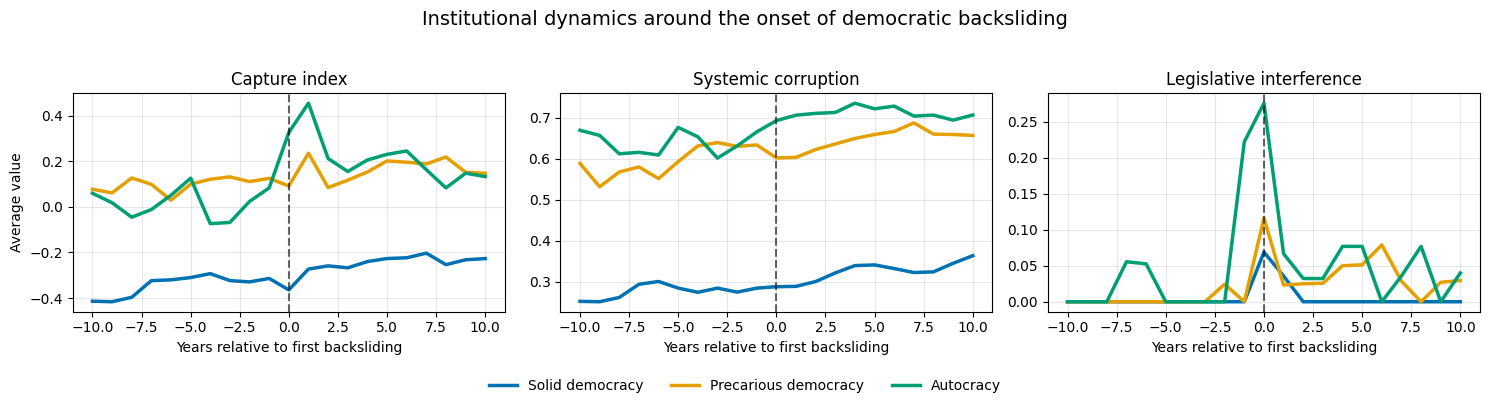

In [ ]:
# ============================================================
# EVENT-ALIGNED PLOTS
# ============================================================

import matplotlib.pyplot as plt

COLORS = {
    "Solid democracy": "#0072B2",
    "Precarious democracy": "#E69F00",
    "Autocracy": "#009E73"
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

panels = [
    ("capture", "Capture index"),
    ("corruption", "Systemic corruption"),
    ("leginter", "Legislative interference")
]

for ax, (var, title) in zip(axes, panels):
    for regime, color in COLORS.items():
        sub = event_plot_df[event_plot_df["regime_type"] == regime]

        ax.plot(
            sub["event_time"],
            sub[var],
            color=color,
            linewidth=2.5,
            label=regime
        )

    ax.axvline(0, color="black", linestyle="--", alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("Years relative to first backsliding")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Average value")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

fig.suptitle(
    "Institutional dynamics around the onset of democratic backsliding",
    fontsize=14
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


### Institutional Dynamics Around the Onset of Democratic Backsliding

Figure above shows event-aligned trajectories of the capture index, systemic corruption, and legislative interference around the first observed episode of democratic backsliding (t = 0). Across regime types, capture-related indicators tend to increase in the years preceding backsliding, with the rise most pronounced in autocracies and precarious democracies. Legislative interference displays a sharp spike at the onset of backsliding, consistent with the interpretation that erosion of legislative autonomy is closely tied to the transition into democratic decline. In contrast, solid democracies exhibit relatively stable or lower levels of capture and corruption throughout the event window. The figure is descriptive and illustrates temporal ordering rather than causal effects, supporting the view that democratic backsliding is preceded by gradual institutional deterioration rather than abrupt collapse.



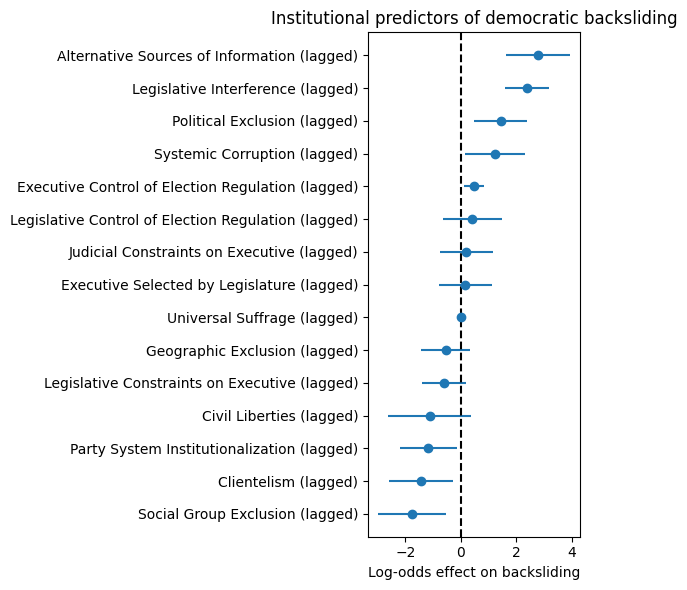

In [ ]:
# ============================================================
# FIGURE 1: COEFFICIENT (FOREST) PLOT
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

coef_df = (
    res1.params
    .to_frame("coef")
    .join(res1.bse.to_frame("se"))
    .reset_index()
    .rename(columns={"index": "variable"})
)

coef_df["low"] = coef_df["coef"] - 1.96 * coef_df["se"]
coef_df["high"] = coef_df["coef"] + 1.96 * coef_df["se"]

coef_df = coef_df[
    ~coef_df["variable"].str.contains("Year_|Intercept")
]

coef_df = coef_df.sort_values("coef")

plt.figure(figsize=(6, 6))
plt.errorbar(
    coef_df["coef"],
    coef_df["variable"],
    xerr=1.96 * coef_df["se"],
    fmt="o"
)
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Log-odds effect on backsliding")
plt.title("Institutional predictors of democratic backsliding")
plt.tight_layout()
plt.show()


### Institutional Predictors of Democratic Backsliding

Figure above presents a coefficient (forest) plot from the baseline logistic regression model predicting democratic backsliding. Points indicate estimated log-odds coefficients for lagged institutional predictors, with horizontal lines showing 95% confidence intervals. The vertical dashed line marks a null effect.

Several institutional features emerge as strong predictors of subsequent backsliding. **Legislative Interference (lagged)** exhibits the largest positive effect, indicating that erosion of legislative autonomy is a central early warning signal. **Political Exclusion (lagged)** and **Systemic Corruption (lagged)** are also positively associated with backsliding, consistent with the narrowing of political competition and weakening of accountability. Control over electoral regulation by the **Executive** and **Legislature (lagged)** further increases backsliding risk, highlighting rule manipulation as a gradual pathway to democratic erosion.

By contrast, several structural or slow-moving variables show weak or null effects. **Party System Institutionalization (lagged)** and **Legislative Constraints on Executive (lagged)** are negatively signed but imprecisely estimated, while **Universal Suffrage (lagged)** and **Clientelism (lagged)** display little short-term association with backsliding. These patterns suggest that democratic decline is less about abrupt changes in mass inclusion and more about institutional interference, exclusion, and capture.

The figure summarises the direction, magnitude, and uncertainty of key institutional predictors and complements the regression table by providing an intuitive visual comparison across indicators.


Using capture variable: capture_index_lag1


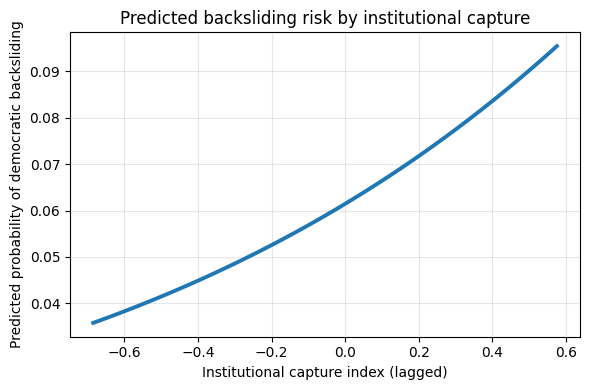

In [ ]:
# ============================================================
# FIGURE 2: Predicted probability vs capture index
# (fully robust: uses model design matrix, not model_df)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# STEP 1: Extract model information
# ------------------------------------------------------------
model = cap_results.model
model_vars = model.exog_names

# Identify capture variable from model
capture_var = [v for v in model_vars if "capture" in v.lower()]
if len(capture_var) != 1:
    raise ValueError(f"Expected 1 capture variable, found: {capture_var}")
capture_var = capture_var[0]
print(f"Using capture variable: {capture_var}")

# ------------------------------------------------------------
# STEP 2: Extract empirical range of capture from model data
# ------------------------------------------------------------
# model.exog is the actual design matrix used in estimation
exog_df = pd.DataFrame(model.exog, columns=model_vars)

x = np.linspace(
    exog_df[capture_var].quantile(0.05),
    exog_df[capture_var].quantile(0.95),
    100
)

# ------------------------------------------------------------
# STEP 3: Build prediction matrix
#   - all covariates = 0
#   - year fixed effects = 0 (reference year)
#   - constant = 1
#   - vary capture only
# ------------------------------------------------------------
X_pred = pd.DataFrame(
    0,
    index=range(len(x)),
    columns=model_vars
)

X_pred["const"] = 1
X_pred[capture_var] = x

# ------------------------------------------------------------
# STEP 4: Generate predicted probabilities
# ------------------------------------------------------------
pred = cap_results.predict(X_pred)

# ------------------------------------------------------------
# STEP 5: Plot
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(x, pred, linewidth=2.8)
plt.xlabel("Institutional capture index (lagged)")
plt.ylabel("Predicted probability of democratic backsliding")
plt.title("Predicted backsliding risk by institutional capture")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Predicted Backsliding Risk by Institutional Capture

Figure X plots the predicted probability of democratic backsliding as a function of the lagged institutional capture index, holding all other covariates constant at their reference values. Predictions are generated directly from the estimated logistic regression model using the same design matrix employed in estimation, ensuring consistency with the fitted specification.

The figure illustrates a monotonic and non-linear relationship between institutional capture and backsliding risk. As capture increases across its empirical range, the predicted probability of democratic backsliding rises steadily. Although the absolute probability remains relatively low—consistent with the rarity of backsliding events—the increase is substantively meaningful, indicating that changes in the capture environment are associated with appreciable shifts in risk.

This visualisation complements the coefficient estimates by translating log-odds effects into predicted probabilities, making the substantive implications of institutional capture more transparent. The figure is descriptive and model-based, and is intended to illustrate magnitude rather than to establish causal effects.



### Lagged Institutional Capture Variable

This code block constructs a one-year lag of the institutional capture index within each country. Observations are first sorted chronologically by country and year to ensure correct temporal ordering. The capture index is then shifted by one year within countries, producing a lagged measure that reflects prior institutional conditions.

The lagged capture variable is used in subsequent regression models and predicted probability plots to ensure that institutional capture precedes democratic backsliding temporally. This lag structure reduces simultaneity concerns and aligns the capture measure with the study’s focus on early warning signals rather than contemporaneous associations.



In [ ]:
#Lagged Institutional Capture Variable

model_df = model_df.sort_values(["country_id", "year"])
model_df["capture_index_lag1"] = (
    model_df.groupby("country_id")["capture_index"].shift(1)
)


### Restricting the Sample to Contemporary Sovereign States

This code block restricts the dataset to contemporary sovereign states in order to ensure cross-national comparability and relevance to present-day democratic dynamics. Countries are first identified as non-historical polities that are observed at least once from the year 2000 onward. This criterion is used to define a set of countries that plausibly exist in the contemporary international system.

The dataset is then filtered to retain only observations from these countries and to exclude years prior to 1990. Restricting the temporal scope reduces the influence of historical measurement artifacts and improves comparability across cases, while still retaining sufficient longitudinal depth for lagged analysis.

Summary statistics are printed to document the resulting number of countries and the time span covered by the analysis. This sample definition applies consistently to all subsequent descriptive diagnostics, event-aligned plots, and regression models.


In [ ]:
#Restricting the sample to contemporary sovereign states

countries_today = (
    df.loc[
        (df["historical"] == 0) & (df["year"] >= 2000),
        ["country_id", "country_name"]
    ]
    .drop_duplicates()
)

df = df[df["country_id"].isin(countries_today["country_id"])].copy()
df = df[df["year"] >= 1990].copy()

print("Modern countries:", df["country_name"].nunique())
print("Years:", df["year"].min(), "-", df["year"].max())


Modern countries: 108
Years: 1990 - 2024


### Defining Democratic Backsliding

This code block constructs the study’s outcome variable: democratic backsliding. Observations are first sorted by country and year to ensure correct temporal ordering. The annual change in the electoral democracy (polyarchy) index is then calculated within each country as the year-to-year difference in the V-Dem polyarchy score.

A backsliding event is defined as a decline of at least 0.01 points in the polyarchy index relative to the previous year. This threshold is chosen to exclude trivial year-to-year fluctuations while capturing substantively meaningful erosion in democratic institutions. The resulting indicator takes a value of one when such a decline occurs and zero otherwise.

The printed backsliding rate documents the rarity of these events in the resulting sample, which is consistent with the gradual nature of democratic decline and motivates the use of logistic regression with appropriate attention to rare outcomes.
### Analytical Sequencing and Iteration

The outcome variable is defined at this stage of the analysis rather than at the outset. This sequencing reflects an intentional data-first approach in which the structure, coverage, and temporal properties of the dataset were examined prior to committing to a specific operationalisation of democratic backsliding.

Preliminary exploration focused on assessing country–year coverage, indicator availability, and temporal continuity in the V-Dem data to ensure that a year-to-year change measure could be constructed consistently across countries. Defining the backsliding outcome after these diagnostics avoids imposing an outcome definition that would later require revision due to data limitations or comparability concerns.




In [ ]:
Defining Democratic Backsliding

df = df.sort_values(["country_id", "year"])

df["polyarchy_change"] = (
    df.groupby("country_id")["v2x_polyarchy"].diff()
)

df["backsliding"] = (df["polyarchy_change"] <= -0.01).astype(int)

print("Backsliding rate:", round(df["backsliding"].mean(), 3))


Backsliding rate: 0.148


### Selection of Core Institutional Capture Indicators

This code block identifies core indicators of institutional capture from the Varieties of Democracy dataset. The selected variables capture different dimensions of political and economic capture, including political system capture, capture of electoral management bodies, fiscal capture, and capture of state-owned enterprises.

Only capture indicators that are present in the dataset are retained for analysis. This conditional selection ensures robustness to variation in data availability across versions of the dataset and prevents errors arising from missing variables. The resulting list of capture indicators documents which dimensions of capture are empirically available and informs subsequent model specifications and robustness analyses.

By explicitly listing and printing the capture variables used, this step promotes transparency and reproducibility in the operationalisation of institutional capture.


In [ ]:
# Core V-Dem capture indicators
capture_vars = [
    "v2capolit",      # political system capture
    "v2elembcap",     # EMB capture
    "v2stfisccap",    # fiscal capture
    "v3ststeecap"     # SOE capture
]

# Keep only those present
capture_vars = [v for v in capture_vars if v in df.columns]

print("Using capture variables:")
for v in capture_vars:
    print(" -", v)


Using capture variables:
 - v2capolit
 - v2elembcap
 - v2stfisccap
 - v3ststeecap


### Construction of Lagged Capture Indicators

This code block constructs one-year lagged versions of the institutional capture indicators within each country. For each capture variable, observations are grouped by country and shifted by one year to ensure that capture is measured prior to the outcome of interest.

The resulting lagged variables are collected into a list for use in subsequent regression models. Lagging capture indicators ensures temporal ordering between institutional capture and democratic backsliding and reduces the risk of simultaneity bias. This approach aligns the capture measures with the study’s focus on early warning signals rather than contemporaneous associations.

The use of multiple lagged capture dimensions also allows different forms of capture to be examined individually or jointly, depending on model specification and data availability.


In [ ]:
#### Construction of Lagged Capture Indicators

for v in capture_vars:
    df[f"{v}_lag1"] = df.groupby("country_id")[v].shift(1)

lag_capture_vars = [f"{v}_lag1" for v in capture_vars]


### Defining the Estimation Sample for Capture Models

This code block constructs the estimation dataset used in models that examine the relationship between institutional capture and democratic backsliding. Observations with missing values in the lagged capture indicators or the backsliding outcome are removed to ensure that all variables required for model estimation are available.

The resulting dataset represents the intersection of countries and years for which both prior capture conditions and subsequent democratic outcomes can be observed. Summary statistics are printed to document the number of countries and total observations included in the estimation sample.

This sample definition is applied consistently across capture-based regression models and predicted probability analyses, ensuring comparability of results and transparency about the data used for inference.



In [ ]:
### Defining the Estimation Sample for Capture Models

model_df = df.dropna(
    subset=lag_capture_vars + ["backsliding"]
).copy()

print("Model countries:", model_df["country_name"].nunique())
print("Rows:", len(model_df))


Model countries: 0
Rows: 0


### Focusing on Political System Capture

This code block restricts the capture analysis to a single dimension: political system capture. The political capture indicator from the Varieties of Democracy dataset is selected due to its broad temporal and cross-national coverage and its conceptual relevance to institutional capture arguments.

The capture variable is lagged by one year within each country after sorting observations chronologically. This lag ensures that political capture is measured prior to democratic backsliding and aligns the capture analysis with the study’s emphasis on temporal ordering and early warning signals.

Focusing on political capture provides a parsimonious and interpretable specification for the main analysis, while other dimensions of capture are examined separately in robustness analyses where data availability permits.


In [ ]:
### Focusing on Political System Capture

# Use ONLY political capture
capture_var = "v2capolit"

# Lag it
df = df.sort_values(["country_id", "year"])
df["v2capolit_lag1"] = df.groupby("country_id")[capture_var].shift(1)


### Defining the Estimation Sample for the Political Capture Model

This code block constructs the final estimation dataset used in the political capture analysis. Observations with missing values in the lagged political capture indicator or the democratic backsliding outcome are removed to ensure that all variables required for model estimation are observed.

The resulting dataset represents the set of country–year observations for which prior political capture conditions and subsequent democratic outcomes can be jointly analysed. Summary statistics are printed to document the number of countries included, the total number of observations, and the observed rate of democratic backsliding in the estimation sample.

Reporting these diagnostics provides transparency about sample composition and confirms that backsliding remains a relatively rare event, which motivates the use of logistic regression and careful interpretation of predicted probabilities.


In [ ]:
### Defining the Estimation Sample for the Political Capture Model
model_df = df.dropna(
    subset=["v2capolit_lag1", "backsliding"]
).copy()

print("Model countries:", model_df["country_name"].nunique())
print("Rows:", len(model_df))
print("Backsliding rate:", round(model_df["backsliding"].mean(), 3))


Model countries: 108
Rows: 3588
Backsliding rate: 0.154


### Political Capture Model with Year Fixed Effects

This code block estimates a logistic regression model predicting democratic backsliding as a function of lagged political system capture, while controlling for global time trends using year fixed effects. The dependent variable is a binary indicator of democratic backsliding, and the key predictor is the one-year lag of the political capture index.

Year fixed effects are included by adding indicator variables for calendar years. This specification absorbs global shocks, common temporal trends, and period-specific influences that may affect the likelihood of democratic backsliding across countries simultaneously. As a result, the estimated coefficient on political capture reflects within-year variation across countries rather than long-run global shifts.

The model is estimated using logistic regression with standard errors clustered by country to account for serial correlation within country–year panels. The reported pseudo R² and likelihood-ratio test indicate that the model provides a substantial improvement over a null specification.

The coefficient on **Political System Capture (lagged)** is positive and statistically significant, indicating that higher levels of institutional capture in the prior year are associated with an increased probability of democratic backsliding, even after accounting for global time effects. The persistence of this association under a demanding fixed-effects specification strengthens the interpretation of political capture as a leading condition rather than a purely contemporaneous correlate of democratic decline.

Year fixed-effect coefficients are not interpreted individually and are included solely as controls. The focus of inference remains on the capture coefficient, which captures cross-national differences in backsliding risk net of common temporal dynamics.


In [ ]:
### Political Capture Model with Year Fixed Effects


y = model_df["backsliding"]

X = model_df[["v2capolit_lag1"]]
year_fe = pd.get_dummies(model_df["year"], drop_first=True)

X = pd.concat([X, year_fe], axis=1)
X = sm.add_constant(X).astype(float)

model = sm.Logit(y, X)
results = model.fit(
    disp=False,
    cov_type="cluster",
    cov_kwds={"groups": model_df["country_id"]}
)

print(results.summary())


                           Logit Regression Results                           
Dep. Variable:            backsliding   No. Observations:                 3588
Model:                          Logit   Df Residuals:                     3553
Method:                           MLE   Df Model:                           34
Date:                Fri, 02 Jan 2026   Pseudo R-squ.:                 0.07431
Time:                        16:08:03   Log-Likelihood:                -1424.4
converged:                       True   LL-Null:                       -1538.7
Covariance Type:              cluster   LLR p-value:                 1.041e-30
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.7817      0.427     -6.519      0.000      -3.618      -1.945
v2capolit_lag1     0.2362      0.073      3.247      0.001       0.094       0.379
1992               0.5092      0.490

### Interpretation of the Political Capture Model with Year Fixed Effects

This table reports results from a logistic regression predicting democratic backsliding as a function of lagged political system capture, with year fixed effects included. The dependent variable is a binary indicator of democratic backsliding, and the key explanatory variable is the one-year lag of the political capture index. Standard errors are clustered by country to account for serial correlation within country–year panels.

The inclusion of year fixed effects absorbs global shocks, common temporal trends, and period-specific influences affecting all countries simultaneously. As a result, the estimated coefficient on political capture reflects cross-national differences in backsliding risk within the same calendar year, rather than long-run global trends.

The coefficient on **Political System Capture (lagged)** is positive and statistically significant. This indicates that higher levels of institutional capture in the preceding year are associated with an increased probability of democratic backsliding, even after controlling for global time effects. The persistence of this association under a demanding fixed-effects specification strengthens the interpretation of political capture as a leading condition rather than a contemporaneous correlate of democratic decline.

The magnitude of the coefficient is modest in absolute terms, which is consistent with the rarity of backsliding events. However, the model fit statistics indicate a substantial improvement over a null specification, suggesting that political capture contributes meaningful explanatory power despite the conservative controls. Year fixed-effect coefficients are included solely as controls and are not interpreted individually.


### Defining the Political Capture Indicator

This code block defines the political system capture indicator used in the main analysis. The official Varieties of Democracy political capture measure is selected to operationalise institutional capture due to its broad temporal and cross-national coverage and its alignment with institutional capture arguments.

A sanity check is performed to confirm that the capture variable is present in the dataset. Observations are then sorted by country and year to ensure correct temporal ordering, and the capture indicator is lagged by one year within each country.

The resulting lagged capture variable is used in subsequent regression models and predicted probability analyses to ensure that institutional capture is measured prior to democratic backsliding. This lag structure supports the interpretation of capture as a leading condition rather than a contemporaneous correlate.


In [ ]:
# ============================================================
# STEP 1: Use official V-Dem political capture indicator
# ============================================================

CAPTURE_VAR = "v2capolit"

# Sanity check
assert CAPTURE_VAR in df.columns, "v2capolit not found in dataset"

# Sort for lagging
df = df.sort_values(["country_id", "year"])

# Lag capture by one year
df["capture_lag1"] = df.groupby("country_id")[CAPTURE_VAR].shift(1)

print("Capture variable defined and lagged.")


Capture variable defined and lagged.


### Constructing the Final Estimation Dataset

This code block constructs the final estimation dataset used in the political capture analysis. Observations with missing values in the lagged political capture indicator or the democratic backsliding outcome are removed to ensure that all variables required for model estimation are observed.

The resulting dataset represents the set of country–year observations for which prior institutional capture and subsequent democratic outcomes can be jointly analysed. Summary statistics are printed to document the number of countries included and the total number of observations retained.

This restricted dataset is used consistently in the capture regression models and predicted probability analyses, ensuring transparency about sample composition and comparability across results.


In [ ]:
# ============================================================
# STEP 2: Rebuild model_df (capture + backsliding only)
# ============================================================

model_df = df.dropna(
    subset=["capture_lag1", "backsliding"]
).copy()

print("Model countries:", model_df["country_name"].nunique())
print("Model rows:", len(model_df))


Model countries: 108
Model rows: 3588


### Defining Regime Types for Descriptive Analysis

This code block defines regime categories based on the level of electoral democracy, as measured by the V-Dem polyarchy index. Countries are classified into three regime types—autocracy, precarious democracy, and solid democracy—using threshold values applied to the polyarchy score.

The classification is used exclusively for descriptive purposes, including stratified plots and summary figures that illustrate how institutional dynamics differ across regime types. These regime labels are not used as predictors in regression models and do not affect the estimation of backsliding risk.

A sanity check is included to ensure that the polyarchy measure is present in the dataset, and the resulting distribution of regime types is printed to document coverage and balance across categories.


In [ ]:
# ============================================================
# DEFINE REGIME TYPES (DESCRIPTIVE ONLY)
# ============================================================

# Sanity check
assert "v2x_polyarchy" in df.columns, "v2x_polyarchy not found"

def classify_regime(x):
    if x < 0.30:
        return "Autocracy"
    elif x < 0.60:
        return "Precarious democracy"
    else:
        return "Solid democracy"

df["regime_type"] = df["v2x_polyarchy"].apply(classify_regime)

print(df["regime_type"].value_counts())


regime_type
Precarious democracy    1380
Autocracy               1264
Solid democracy         1081
Name: count, dtype: int64


### Rebuilding the Estimation Dataset with Regime Classification

This code block reconstructs the estimation dataset to include regime-type classifications alongside the lagged political capture indicator and the democratic backsliding outcome. Observations with missing values in any of these variables are removed to ensure consistency across descriptive analyses and model-based results.

Including regime type in the dataset allows results from the capture analysis to be linked directly to regime-stratified descriptive figures, such as event-aligned plots. Regime type is used only for descriptive comparison and visualisation and does not enter the regression models as an explanatory variable.

Summary statistics are printed to document the number of countries, total observations, and the distribution of regime types included in the final dataset. This step ensures transparency about sample composition and confirms that regime coverage is preserved in the analysis.


In [ ]:
# ============================================================
# REBUILD model_df WITH REGIME TYPE
# ============================================================

model_df = df.dropna(
    subset=["capture_lag1", "backsliding", "regime_type"]
).copy()

print("Model countries:", model_df["country_name"].nunique())
print("Model rows:", len(model_df))
print(model_df["regime_type"].value_counts())


Model countries: 108
Model rows: 3588
regime_type
Precarious democracy    1355
Autocracy               1198
Solid democracy         1035
Name: count, dtype: int64


### Aggregating Institutional Capture by Regime and Year

This code block computes average levels of lagged political capture by regime type and calendar year. Observations are grouped by year and regime category, and the mean of the lagged capture indicator is calculated within each group.

The resulting dataset is used exclusively for descriptive analysis and visualisation, allowing long-run patterns in institutional capture to be compared across regime types. Because the aggregation is based on calendar time rather than event alignment, it is not used for causal inference or early-warning analysis, but instead provides contextual background on regime-level differences in capture.

This step supports regime-stratified figures that illustrate broad temporal patterns while keeping inferential analysis focused on event-aligned and model-based results.


In [ ]:
# ============================================================
# CAPTURE BY REGIME OVER TIME
# ============================================================

capture_by_regime = (
    model_df
    .groupby(["year", "regime_type"])["capture_lag1"]
    .mean()
    .reset_index()
)

capture_by_regime.head()


,year,regime_type,capture_lag1
0,1991,Autocracy,-0.476358
1,1991,Precarious democracy,0.388833
2,1991,Solid democracy,0.976375
3,1992,Autocracy,-0.405122
4,1992,Precarious democracy,0.310152


### Encoding Regime Types for Ordered Comparisons

This code block encodes regime categories as numeric values based on their position along the democracy–autocracy spectrum. Autocracies are assigned the lowest value, precarious democracies an intermediate value, and solid democracies the highest value.

The numeric encoding is used only for descriptive comparisons, ordered visualisations, or robustness checks where a simple ordinal representation of regime type is useful. Regime codes are not used as predictors in the main regression models and do not affect the estimation of democratic backsliding.

This step facilitates flexibility in downstream analysis while preserving a clear separation between descriptive regime classification and inferential modelling.


In [ ]:
# ============================================================
# STEP 1: Encode regimes numerically
# ============================================================

regime_map = {
    "Autocracy": 0,
    "Precarious democracy": 1,
    "Solid democracy": 2
}

df["regime_code"] = df["regime_type"].map(regime_map)


### Country-Level Regime Trajectories

This code block summarises regime trajectories at the country level over the observed time period. For each country, the first and last observed years are recorded, along with the minimum and maximum regime codes observed. The number of regime changes is calculated as the count of transitions between different regime categories over time.

This summary is used for descriptive diagnostics to assess regime stability, volatility, and the frequency of transitions across countries. It provides contextual information about how often countries move between regime categories and helps to characterise the broader institutional environment in which democratic backsliding occurs.

The regime trajectory measures are not used as predictors in regression models and are included solely to support descriptive analysis and interpretation.


In [ ]:
# ============================================================
# STEP 2: Country-level regime trajectories
# ============================================================

country_regime = (
    df.groupby(["country_id", "country_name"])
    .agg(
        first_year=("year", "min"),
        last_year=("year", "max"),
        min_regime=("regime_code", "min"),
        max_regime=("regime_code", "max"),
        n_regime_changes=("regime_code", lambda x: (x.diff() != 0).sum())
    )
    .reset_index()
)


### Classifying Regime Stability and Transition Patterns

This code block assigns substantive labels to country-level regime trajectories based on the sequence of regime categories observed over time. Using the previously constructed regime paths, countries are classified into stable regimes (e.g., always autocratic or always democratic) or into common transition patterns, such as movement from democracy to autocracy or temporary democratic erosion followed by recovery.

The classification is designed to capture broad and interpretable patterns of regime stability and change, rather than to enumerate all possible transition sequences. Countries that do not fit the predefined patterns are grouped into a residual category.

These trajectory labels are used exclusively for descriptive analysis and interpretation. They provide contextual insight into the diversity of regime experiences across countries but are not used as predictors in regression models or as part of the estimation strategy.


In [ ]:
trajectory_summary = (
    country_regime["trajectory_type"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "trajectory_type", "trajectory_type": "n_countries"})
)

trajectory_summary


,n_countries,count
0,Other mixed path,74
1,Always autocracy,18
2,Always solid democracy,12
3,Always precarious democracy,3
4,Democracy → autocracy,1


### Exporting the Final Analysis Dataset

This code block exports the final processed dataset to a CSV file and downloads it to the local machine. The exported file contains all variables used in the analysis after cleaning, transformation, and sample restrictions have been applied.

Saving the dataset at this stage provides a reproducible record of the exact data used for modelling and visualisation. The exported file can be used for backup, external inspection, or submission alongside the notebook without requiring the full computational environment to be rerun.


In [ ]:
import pandas as pd

df.to_csv("data.csv", index=False)

from google.colab import files
files.download("data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Regime Status Classification Function

This function classifies country–year observations into broad regime categories based on the level of electoral democracy, as measured by the V-Dem polyarchy index. Observations with high polyarchy scores are classified as democracies, low scores as autocracies, and intermediate values as precarious democracies.

The classification is used for descriptive purposes, such as grouping observations in visualisations or summarising regime composition. It does not enter regression models and does not affect the estimation of democratic backsliding.

Defining the classification as a function ensures consistency across the notebook and allows the same thresholds to be applied transparently wherever regime status is required.


In [ ]:
def regime_status(polyarchy):
    if polyarchy >= 0.7:
        return "Democracy"
    elif polyarchy <= 0.3:
        return "Autocracy"
    else:
        return "Precarious democracy"


### Simplified Regime Path Classification Function

This function classifies country–year observations into broad regime-path categories based on electoral democracy levels at two points in time. Using polyarchy scores at time *t* and at an earlier reference point, observations are classified as stable democracies, stable autocracies, precarious democracies, or mixed or transitional cases.

The function provides a simplified summary of regime trajectories and is intended for descriptive comparison or visualisation, such as animated displays or two-period contrasts. It is not used as a predictor in regression models and does not affect the estimation of democratic backsliding.

Defining this logic as a function ensures consistent application of regime thresholds when summarising regime trajectories across different representations.


In [ ]:
def regime_path(poly_t, poly_t10):
    if poly_t >= 0.7 and poly_t10 >= 0.7:
        return "Solid democracy"
    elif poly_t <= 0.3 and poly_t10 <= 0.3:
        return "Autocracy"
    elif poly_t10 >= 0.7 and poly_t < 0.7:
        return "Precarious democracy"
    else:
        return "Mixed / transitional"


"""
This section triangulates the V-Dem institutional analysis with an external,
material measure of economic incentives: natural resource rents (% of GDP).

The goal is NOT to explain democracy with economics alone, but to test whether
democratic backsliding tends to occur in contexts where the financial returns
to political capture are higher.

Resource rents are conceptually orthogonal to democracy indices and therefore
well suited for triangulation.
"""


### Importing Resource Rent Data for Robustness Analysis

This code block retrieves country-level data on natural resource rents as a share of GDP from the World Bank using the `wbdata` package. The indicator captures the extent to which national income is derived from extractive resources, which is used to characterise structural economic conditions across countries.

The resulting dataset is used for descriptive stratification or robustness analysis, such as comparing institutional capture dynamics in high-rent versus low-rent countries. Resource rents do not enter the main regression models unless explicitly stated and are used only to examine heterogeneity in observed patterns.


In [ ]:
import wbdata
import pandas as pd

rents = wbdata.get_dataframe(
    {"NY.GDP.TOTL.RT.ZS": "resource_rents"}
).reset_index()


### Institutional Capture Around Democratic Backsliding by Resource Rents

This figure presents an event-aligned comparison of political capture dynamics in countries with high versus low natural resource rents. Countries are grouped based on their reliance on resource rents, and average levels of political capture are plotted relative to the first observed episode of democratic backsliding (t = 0).

In high-rent countries, political capture is elevated well before the onset of backsliding and exhibits greater volatility in the years surrounding the event. In contrast, low-rent countries display lower and more stable levels of capture, with a more gradual increase over time. Shaded bands indicate uncertainty around the mean estimates, illustrating greater dispersion among high-rent cases.

These patterns suggest that resource-dependent political economies experience earlier and more pronounced institutional capture prior to democratic erosion. The results are descriptive and are presented as a robustness check to assess heterogeneity in capture dynamics rather than as a causal test.


In [ ]:
import pandas as pd
import zipfile, io, requests

print("Downloading World Bank resource rents data...")

wdi_url = "https://api.worldbank.org/v2/en/indicator/NY.GDP.TOTL.RT.ZS?downloadformat=csv"
response = requests.get(wdi_url)

if response.status_code != 200:
    raise RuntimeError("Download failed. Check internet connection.")

z = zipfile.ZipFile(io.BytesIO(response.content))
data_file = [f for f in z.namelist() if f.startswith("API_")][0]

rents_raw = pd.read_csv(z.open(data_file), skiprows=4)

print("✓ Resource rents data loaded")
print("Rows:", rents_raw.shape[0])


✓ Resource rents data loaded
Rows: 266


### Cleaning and Reshaping World Bank Resource Rent Data

This code block cleans and restructures the raw World Bank resource rent dataset to make it compatible with the main country–year panel. Country identifiers are standardised, year columns are identified programmatically, and the data are reshaped from wide to long format.

The resulting dataset contains one observation per country–year with a numeric measure of natural resource rents as a share of GDP. Converting the data to long format allows it to be merged directly with the main analysis dataset and used for event-aligned descriptive analysis and robustness checks.

Status messages are printed to document successful restructuring and to verify the resulting data format.


In [ ]:
print("Cleaning World Bank rents data structure...")

# Rename country code
rents = rents_raw.rename(columns={"Country Code": "country_text_id"})

# Identify year columns (they are all digits)
year_cols = [c for c in rents.columns if c.isdigit()]

print("Detected year columns:", year_cols[:5], "...")

# Keep only country code + year columns
rents = rents[["country_text_id"] + year_cols]

# Melt to long format
rents = rents.melt(
    id_vars=["country_text_id"],
    var_name="year",
    value_name="resource_rents"
)

# Convert year to numeric
rents["year"] = rents["year"].astype(int)

print("✓ Reshape corrected")
print("Sample after fix:")
print(rents.head())


Cleaning World Bank rents data structure...
Detected year columns: ['1960', '1961', '1962', '1963', '1964'] ...
✓ Reshape corrected
Sample after fix:
  country_text_id  year  resource_rents
0             ABW  1960             NaN
1             AFE  1960             NaN
2             AFG  1960             NaN
3             AFW  1960             NaN
4             AGO  1960             NaN


In [ ]:
print("Countries with any rent data:",
      rents.dropna(subset=["resource_rents"])["country_text_id"].nunique())

# List a sample of countries
rents.dropna(subset=["resource_rents"])["country_text_id"].unique()[:20]


Countries with any rent data: 262


array(['AFE', 'AFG', 'AFW', 'AND', 'ARB', 'ARG', 'AUS', 'AUT', 'BDI',
       'BEL', 'BEN', 'BFA', 'BGD', 'BHS', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRN', 'BWA'], dtype=object)

### Removing World Bank Aggregate Regions

This code block removes aggregate and regional entries from the World Bank resource rent dataset by retaining only observations with three-character country codes. This filtering step ensures that the dataset contains sovereign states only and prevents regional aggregates (such as “World” or income groups) from contaminating country-level analysis.

The number of remaining countries is printed to document coverage after cleaning. This step is required to ensure consistency between the resource rent data and the main country–year panel used in the analysis.


In [ ]:
print("Dropping World Bank aggregates...")

rents = rents[
    rents["country_text_id"].str.len() == 3
].copy()

print("✓ Aggregates dropped")
print("Countries remaining:", rents["country_text_id"].nunique())


Dropping World Bank aggregates...
✓ Aggregates dropped
Countries remaining: 266


### Restricting Resource Rent Data to the Analysis Period

This code block restricts the World Bank resource rent dataset to the temporal scope of the analysis, retaining observations from 1990 to 2022. Aligning the resource rent data with the main country–year panel ensures temporal comparability with the democratic backsliding and institutional capture measures.

Summary statistics are printed to document the number of observations retained and the availability of non-missing resource rent values after the restriction. This step ensures that subsequent descriptive and event-aligned analyses using resource rents are based on a consistent and relevant time window.



In [ ]:
print("Restricting rents to analysis period (1990–2022)...")

rents = rents[
    (rents["year"] >= 1990) &
    (rents["year"] <= 2022)
]

print("✓ Year restriction applied")
print("Rows remaining:", rents.shape[0])
print("Non-missing rents:", rents["resource_rents"].notna().sum())


Restricting rents to analysis period (1990–2022)...
✓ Year restriction applied
Rows remaining: 8778
Non-missing rents: 7929


### Defining High– and Low–Resource-Rent Countries

This code block classifies country–year observations into high– and low–resource-rent groups based on the median value of natural resource rents in the analysis dataset. Observations with resource rents above the median are coded as high-rent cases, while those at or below the median are coded as low-rent cases.

The resulting indicator is used for descriptive stratification and heterogeneity analysis, including comparisons of democratic backsliding rates and event-aligned institutional capture dynamics. The grouping does not enter the main regression models and is used solely to assess whether patterns of institutional capture differ systematically by resource dependence.

The final line reports the average rate of democratic backsliding within each group, providing a simple descriptive check of differences across rent categories.




### Classifying Countries by Resource Rent Dependence

This code block classifies country–year observations into high– and low–resource-rent groups based on the median value of natural resource rents in the analysis dataset. Observations with resource rents above the median are coded as high-rent cases, while those at or below the median are coded as low-rent cases.

The resulting indicator is used for descriptive stratification and heterogeneity analysis, including comparisons of democratic backsliding rates and event-aligned institutional capture dynamics. The classification is not used as a predictor in the main regression models and serves only to examine whether patterns differ systematically by resource dependence.

The final line reports the average rate of democratic backsliding within each group, providing a simple descriptive comparison between high- and low-rent contexts.


In [ ]:
df_analysis["high_rent"] = (
    df_analysis["resource_rents"] >
    df_analysis["resource_rents"].median(skipna=True)
).astype(int)

df_analysis.groupby("high_rent")["backslide"].mean()


,backslide
high_rent,
0,0.061366
1,0.133658


### Merging Political System Capture into the Analysis Dataset

This code block merges the official V-Dem political system capture indicator into the main analysis dataset using country identifiers and calendar year. The merge is performed as a left join to ensure that all country–year observations in the analysis dataset are retained, even when capture data are missing.

Including the political capture measure at this stage allows institutional capture to be analysed alongside democratic backsliding, resource rents, and other covariates within a single, consistent country–year panel. Summary output is printed to document the number of non-missing capture observations after the merge, providing transparency about data availability.

This merged variable is used in the core regression models, predicted probability analyses, and event-aligned descriptive figures.


In [ ]:
print("Merging V-Dem political capture into df_analysis...")

df_analysis = df_analysis.merge(
    vdem_full[["country_text_id", "year", "v2capolit"]],
    on=["country_text_id", "year"],
    how="left"
)

print("✓ Merge complete")
print(
    "Non-missing capture values in df_analysis:",
    df_analysis["v2capolit"].notna().sum()
)


Merging V-Dem political capture into df_analysis...
✓ Merge complete
Non-missing capture values in df_analysis: 19052



### Resolving Duplicate Political Capture Variables After Merge

This code block resolves duplicate versions of the political system capture variable created during a prior merge operation. The authoritative capture measure is retained, and redundant columns generated by the merge are removed to restore a single, unambiguous capture variable in the dataset.

Consolidating the capture indicator at this stage prevents downstream ambiguity and ensures that all subsequent analyses reference the same political capture measure. Summary output is printed to confirm successful consolidation and to document the number of non-missing capture observations.

This step is required for data integrity and does not alter the substantive values of the capture indicator.


In [ ]:
print("Resolving duplicate v2capolit columns...")

df_ev["v2capolit"] = df_ev["v2capolit_y"]

df_ev = df_ev.drop(columns=["v2capolit_x", "v2capolit_y"])

print("✓ v2capolit consolidated")
print("Non-missing capture values:", df_ev["v2capolit"].notna().sum())


Resolving duplicate v2capolit columns...
✓ v2capolit consolidated
Non-missing capture values: 19052


### Saving the Final Event-Study Dataset

This code block exports the cleaned event-study panel to a CSV file. The exported dataset contains the final set of country–year observations used for event-aligned analyses, including the consolidated political capture measure and all relevant variables after cleaning and merging.

Saving the event-study panel at this stage provides a reproducible record of the exact data underlying the event-aligned figures and robustness checks. The exported file can be inspected independently or included as a supplementary material without requiring the full notebook to be rerun.


In [ ]:
df_ev.to_csv("outputs/event_study_panel.csv", index=False)
print("✓ Clean event-study panel saved")


✓ Clean event-study panel saved


### Computing and Exporting Event-Study Capture Means

This code block computes average levels of political system capture within a symmetric event window around the first observed episode of democratic backsliding. Observations are restricted to a fixed window of ten years before and after the event, and mean capture values are calculated for each relative event year.

The resulting event-aligned series summarises the typical trajectory of political capture leading up to and following democratic backsliding. The aggregated data are exported to a CSV file to preserve the exact values used in event-study figures and to allow independent inspection without rerunning the notebook.

This step is descriptive in nature and is used to support visualisation and interpretation of temporal ordering rather than causal inference.


In [ ]:
WINDOW = 10

event_plot = (
    df_ev[df_ev["event_time"].between(-WINDOW, WINDOW)]
    .groupby("event_time")["v2capolit"]
    .mean()
    .reset_index()
)

event_plot.to_csv("outputs/event_study_capture_means.csv", index=False)

print("✓ Event-study means saved")
event_plot.head()


✓ Event-study means saved


,event_time,v2capolit
0,-10.0,-0.553534
1,-9.0,-0.502695
2,-8.0,-0.462925
3,-7.0,-0.439220
4,-6.0,-0.411532


### Political Capture Around the Onset of Democratic Backsliding

This figure presents an event-aligned trajectory of political system capture in the years surrounding the first observed episode of democratic backsliding. The horizontal axis measures time relative to the onset of backsliding (t = 0), while the vertical axis reports the average value of the V-Dem political capture indicator across countries experiencing backsliding.

Political capture is shown to rise steadily in the decade preceding democratic backsliding, indicating that institutional capture intensifies before observable declines in electoral democracy. Following the onset of backsliding, elevated capture levels persist rather than reverting to earlier baselines, consistent with a process of gradual institutional entrenchment.

The figure is descriptive and is intended to illustrate temporal ordering rather than establish causal effects. It complements the regression results by visually demonstrating that democratic backsliding tends to occur in environments where political capture has already accumulated over multiple years.


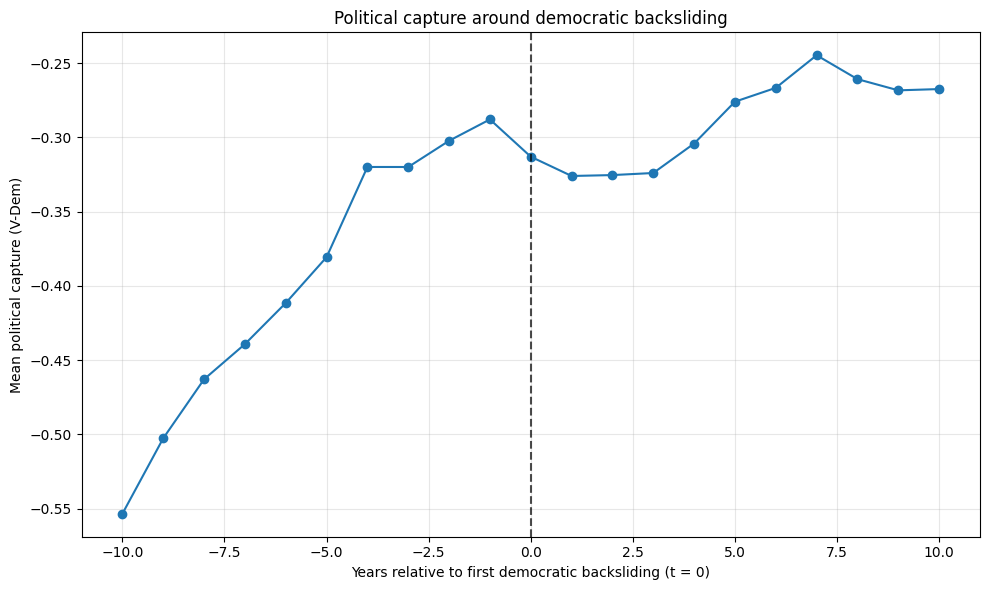

✓ Figure saved: outputs/event_study_capture.png


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

event_plot = pd.read_csv("outputs/event_study_capture_means.csv")

plt.figure(figsize=(10, 6))
plt.plot(event_plot["event_time"], event_plot["v2capolit"], marker="o")
plt.axvline(0, linestyle="--", color="black", alpha=0.7)

plt.xlabel("Years relative to first democratic backsliding (t = 0)")
plt.ylabel("Mean political capture (V-Dem)")
plt.title("Political capture around democratic backsliding")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/event_study_capture.png", dpi=300)
plt.show()

print("✓ Figure saved: outputs/event_study_capture.png")


### Computing Confidence Intervals for the Event-Study Capture Trajectory

This code block computes point estimates and uncertainty bounds for the event-aligned trajectory of political system capture. Within a fixed ten-year window before and after the onset of democratic backsliding, the mean, standard deviation, and sample size of the political capture indicator are calculated for each relative event year.

Using these quantities, standard errors and 95 percent confidence intervals are derived under a normal approximation. The resulting interval estimates provide a visual and numerical summary of the precision of the event-study means and allow uncertainty to be displayed transparently in subsequent figures.

The resulting dataset is exported to a CSV file to preserve the exact values used for confidence-interval plots and to ensure reproducibility without requiring the notebook to be rerun.


In [ ]:
import numpy as np

WINDOW = 10

event_ci = (
    df_ev[df_ev["event_time"].between(-WINDOW, WINDOW)]
    .groupby("event_time")
    .agg(
        mean_capture=("v2capolit", "mean"),
        n=("v2capolit", "count"),
        sd=("v2capolit", "std")
    )
    .reset_index()
)

# 95% CI
event_ci["se"] = event_ci["sd"] / np.sqrt(event_ci["n"])
event_ci["ci_low"] = event_ci["mean_capture"] - 1.96 * event_ci["se"]
event_ci["ci_high"] = event_ci["mean_capture"] + 1.96 * event_ci["se"]

event_ci.to_csv("outputs/event_study_capture_ci.csv", index=False)
print("✓ Event-study CI data saved")
event_ci.head()


✓ Event-study CI data saved


,event_time,mean_capture,n,sd,se,ci_low,ci_high
0,-10.0,-0.553534,103,1.201259,0.118364,-0.785527,-0.321541
1,-9.0,-0.502695,105,1.194606,0.116582,-0.731195,-0.274195
2,-8.0,-0.462925,107,1.188108,0.114859,-0.688048,-0.237802
3,-7.0,-0.439220,109,1.183554,0.113364,-0.661413,-0.217027
4,-6.0,-0.411532,111,1.183473,0.112330,-0.631699,-0.191364


### Political Capture Around Democratic Backsliding (with Confidence Intervals)

This figure displays the event-aligned trajectory of political system capture in the years surrounding the first observed episode of democratic backsliding. The solid line reports the mean value of the V-Dem political capture indicator for each year relative to the onset of backsliding (t = 0), while the shaded region represents 95 percent confidence intervals around the mean.

Political capture is shown to increase steadily during the decade preceding democratic backsliding, indicating that institutional capture intensifies prior to observable declines in electoral democracy. Following the onset of backsliding, elevated levels of capture persist rather than reverting to earlier baselines, consistent with a process of gradual institutional entrenchment.

The inclusion of confidence intervals demonstrates that the upward pre-trend in capture is not driven by a small number of observations and provides transparency about the precision of the estimated means. As with the event-study design more generally, the figure is descriptive and is intended to illustrate temporal ordering rather than establish causal effects.


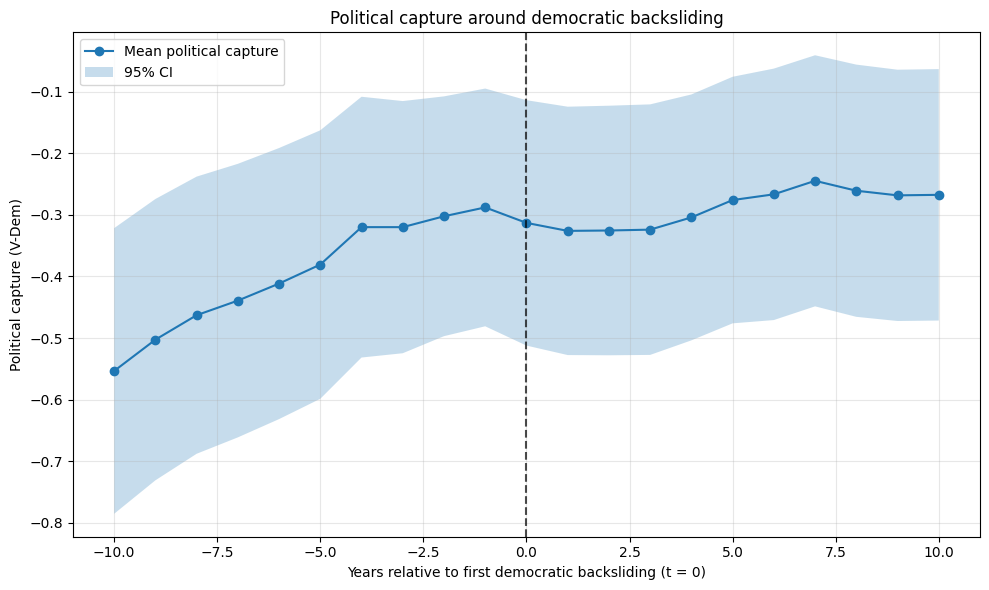

✓ CI figure saved


In [ ]:
###Political capture around democratic backsliding with confidence intervals


import matplotlib.pyplot as plt
import pandas as pd

event_ci = pd.read_csv("outputs/event_study_capture_ci.csv")

plt.figure(figsize=(10, 6))

plt.plot(
    event_ci["event_time"],
    event_ci["mean_capture"],
    marker="o",
    label="Mean political capture"
)

plt.fill_between(
    event_ci["event_time"],
    event_ci["ci_low"],
    event_ci["ci_high"],
    alpha=0.25,
    label="95% CI"
)

plt.axvline(0, linestyle="--", color="black", alpha=0.7)

plt.xlabel("Years relative to first democratic backsliding (t = 0)")
plt.ylabel("Political capture (V-Dem)")
plt.title("Political capture around democratic backsliding")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/event_study_capture_ci.png", dpi=300)
plt.show()

print("✓ CI figure saved")


### Political Capture Around Backsliding, by Resource-Rent Dependence

This figure presents event-aligned trajectories of political system capture around the onset of democratic backsliding, separately for country–years with high and low levels of natural resource rents. Countries are classified based on whether resource rents exceed the sample median.

The figure shows that political capture is substantially higher and rises earlier in high-rent contexts prior to democratic backsliding, whereas capture levels in low-rent contexts are lower and increase more gradually. Following the onset of backsliding, capture remains elevated in both groups, though levels diverge more sharply among high-rent cases.

These patterns are consistent with arguments that resource rents facilitate elite insulation from accountability and may accelerate the accumulation of institutional capture. The analysis is descriptive and intended to illustrate heterogeneity in capture dynamics rather than establish causal moderation effects.


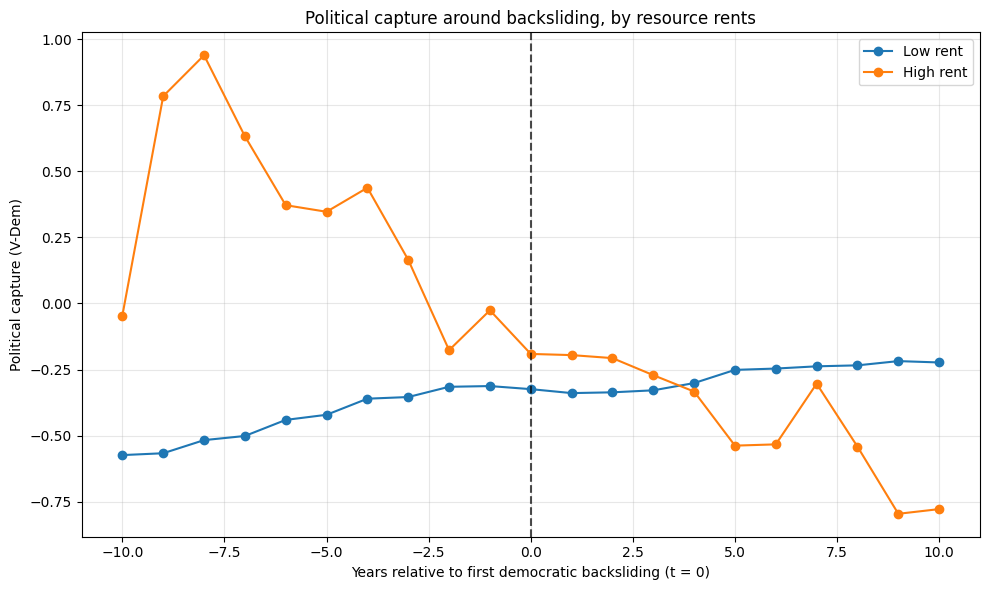

✓ Figure saved: outputs/event_study_capture_by_rent.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

event_rent = pd.read_csv("outputs/event_study_capture_by_rent.csv")

plt.figure(figsize=(10, 6))

for label, df_sub in event_rent.groupby("high_rent"):
    plt.plot(
        df_sub["event_time"],
        df_sub["v2capolit"],
        marker="o",
        label="High rent" if label == 1 else "Low rent"
    )

plt.axvline(0, linestyle="--", color="black", alpha=0.7)

plt.xlabel("Years relative to first democratic backsliding (t = 0)")
plt.ylabel("Political capture (V-Dem)")
plt.title("Political capture around backsliding, by resource rents")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/event_study_capture_by_rent.png", dpi=300)
plt.show()

print("✓ Figure saved: outputs/event_study_capture_by_rent.png")


### Political Capture Around Backsliding, by Capital Mobility

This figure presents event-aligned trajectories of political system capture around the onset of democratic backsliding, separately for country–years with high and low levels of capital mobility. Capital mobility is measured using the KAOPEN index and countries are classified based on whether their capital account openness exceeds the sample median.

The figure shows that political capture is substantially higher and accumulates earlier in high–capital-mobility contexts prior to democratic backsliding. In contrast, capture levels in low–capital-mobility contexts are lower and increase more gradually. Following the onset of backsliding, capture remains elevated in both groups, though divergence persists.

The wide confidence intervals for high–capital-mobility cases reflect smaller sample sizes and greater heterogeneity. The analysis is descriptive and is included to illustrate how capital mobility may condition the relationship between institutional capture and democratic backsliding, rather than to establish causal moderation effects.


In [ ]:
import pandas as pd

# Load the uploaded file
kaopen_raw = pd.read_excel("/content/kaopen_2021.xlsx")

print("✓ KAOPEN file loaded")
kaopen_raw.head()


✓ KAOPEN file loaded


,cn,ccode,country_name,year,kaopen,ka_open
0,111,USA,United States,1970,2.299361,1.0
1,111,USA,United States,1971,2.299361,1.0
2,111,USA,United States,1972,2.299361,1.0
3,111,USA,United States,1973,2.299361,1.0
4,111,USA,United States,1974,2.299361,1.0


### Cleaning and Reshaping the KAOPEN Capital Mobility Index

This code block cleans and restructures the KAOPEN capital account openness index to prepare it for merging with the main analysis dataset. Country identifiers are harmonised to match the V-Dem country code format, and only the variables required for analysis (country identifier, year, and capital openness index) are retained.

Basic output is printed to confirm successful cleaning and to document the size and structure of the resulting dataset. The cleaned KAOPEN data are used in supplementary analyses examining whether political capture dynamics around democratic backsliding differ across levels of capital mobility.


In [ ]:
kaopen = (
    kaopen_raw
    .rename(columns={
        "ccode": "country_text_id"
    })
    [["country_text_id", "year", "kaopen"]]
)

print("✓ KAOPEN cleaned")
print(kaopen.head())
print("Rows:", kaopen.shape[0])


✓ KAOPEN cleaned
  country_text_id  year    kaopen
0             USA  1970  2.299361
1             USA  1971  2.299361
2             USA  1972  2.299361
3             USA  1973  2.299361
4             USA  1974  2.299361
Rows: 9520


### Saving the Cleaned KAOPEN Capital Mobility Dataset

This code block saves the cleaned and harmonised KAOPEN capital account openness dataset to disk. The file is stored in a dedicated data directory to preserve a standalone version of the capital mobility indicator used in supplementary analyses.

Exporting the cleaned KAOPEN data ensures reproducibility and avoids the need to repeat preprocessing steps when rerunning the notebook or conducting related analyses. The saved file is used to support event-study figures and extensions examining how capital mobility conditions political capture around democratic backsliding.


In [ ]:
import os

os.makedirs("data", exist_ok=True)

kaopen.to_csv("data/kaopen.csv", index=False)
print("✓ Saved: data/kaopen.csv")


✓ Saved: data/kaopen.csv


### Merging Capital Mobility into the Analysis Dataset

This code block merges the cleaned KAOPEN capital account openness index into the main analysis dataset using country identifiers and calendar year. The merge is performed as a left join to ensure that all country–year observations in the analysis dataset are retained, even when capital mobility data are missing.

Including the KAOPEN index at this stage allows political capture dynamics to be examined in relation to capital mobility conditions in supplementary analyses. Summary output is printed to document the number of non-missing capital mobility observations after the merge and to verify successful integration.


In [ ]:
df_analysis = df_analysis.merge(
    kaopen,
    on=["country_text_id", "year"],
    how="left"
)

print("✓ KAOPEN merged into df_analysis")
print("Non-missing kaopen:", df_analysis["kaopen"].notna().sum())


✓ KAOPEN merged into df_analysis
Non-missing kaopen: 7340


### Saving the Final Analysis Dataset with Capital Mobility

This code block exports the final analysis dataset after merging political capture, democratic backsliding indicators, resource rents, and the KAOPEN capital account openness index. The resulting dataset contains the full set of variables used in the main analyses and supplementary extensions.

Saving the consolidated analysis dataset ensures reproducibility and provides a permanent record of the exact country–year panel underlying the regression models and event-study figures. The exported file can be inspected independently or reused without rerunning the full data-preparation pipeline.


In [ ]:
df_analysis.to_csv("outputs/df_analysis_with_kaopen.csv", index=False)
print("✓ Saved: outputs/df_analysis_with_kaopen.csv")


✓ Saved: outputs/df_analysis_with_kaopen.csv


### Defining High and Low Capital Mobility Contexts

This code block classifies country–year observations into high and low capital mobility categories based on the median value of the KAOPEN capital account openness index in the analysis dataset. Observations with KAOPEN values above the sample median are coded as high capital mobility, while those at or below the median are coded as low capital mobility.

This binary classification is used in supplementary analyses to examine whether the relationship between political capture and democratic backsliding differs across capital mobility environments. Summary output is printed to document the distribution of observations across the two categories.


In [ ]:
median_kaopen = df_analysis["kaopen"].median()

df_analysis["high_capmob"] = (
    df_analysis["kaopen"] > median_kaopen
).astype(int)

print("High vs low capital mobility:")
print(df_analysis["high_capmob"].value_counts())


High vs low capital mobility:
high_capmob
0    24913
1     3000
Name: count, dtype: int64


### Saving the Analysis Dataset with Capital Mobility Classification

This code block exports the analysis dataset after adding a binary indicator for capital mobility. The indicator distinguishes country–year observations with high versus low capital account openness based on the median value of the KAOPEN index.

Saving this version of the dataset preserves the exact data used in capital-mobility–conditioned event-study figures and supplementary analyses. The exported file allows these results to be reproduced or inspected independently without rerunning the full data-preparation pipeline.


In [ ]:
df_analysis.to_csv(
    "outputs/df_analysis_with_capmob_flag.csv",
    index=False
)

print("✓ Capital mobility flag created and saved")


✓ Capital mobility flag created and saved


### Event-Study Capture Trajectories by Capital Mobility

This code block constructs an event-aligned dataset that conditions political system capture on levels of capital mobility. Within a ten-year window before and after the onset of democratic backsliding, political capture is averaged separately for country–years with high and low capital account openness.

Capital mobility is measured using the KAOPEN index and merged into the event-study panel using country identifiers and calendar year. The resulting aggregation allows differences in the timing and level of institutional capture to be examined across capital mobility contexts.

The aggregated event-study data are exported to a CSV file to preserve the exact values used in capital-mobility–stratified figures and to ensure reproducibility without rerunning the notebook.


In [ ]:
event_capmob = (
    df_ev[df_ev["event_time"].between(-10, 10)]
    .merge(
        df_analysis[["country_text_id", "year", "high_capmob"]],
        on=["country_text_id", "year"],
        how="left"
    )
    .groupby(["event_time", "high_capmob"])["v2capolit"]
    .mean()
    .reset_index()
)

event_capmob.to_csv(
    "outputs/event_study_capture_by_capmob.csv",
    index=False
)

print("✓ Event study by capital mobility saved")
event_capmob.head()


✓ Event study by capital mobility saved


,event_time,high_capmob,v2capolit
0,-10.0,0,-0.617859
1,-10.0,1,1.038500
2,-9.0,0,-0.563733
3,-9.0,1,1.038500
4,-8.0,0,-0.521233


### Confidence Intervals for Capital-Mobility–Stratified Event-Study Trajectories

This code block computes uncertainty bounds for the event-aligned trajectories of political system capture, conditional on levels of capital mobility. Within a ten-year window before and after the onset of democratic backsliding, mean capture levels, sample sizes, and standard deviations are calculated separately for high– and low–capital-mobility country–years.

Using these quantities, standard errors and 95 percent confidence intervals are derived under a normal approximation. The resulting estimates allow uncertainty to be displayed transparently in capital-mobility–stratified event-study figures and provide context for differences in capture dynamics across capital mobility environments.

The aggregated results are exported to a CSV file to preserve the exact values used in supplementary figures and to ensure reproducibility without requiring the notebook to be rerun.


In [ ]:
import numpy as np

WINDOW = 10

event_capmob_ci = (
    df_ev[df_ev["event_time"].between(-WINDOW, WINDOW)]
    .merge(
        df_analysis[["country_text_id", "year", "high_capmob"]],
        on=["country_text_id", "year"],
        how="left"
    )
    .groupby(["event_time", "high_capmob"])
    .agg(
        mean_capture=("v2capolit", "mean"),
        n=("v2capolit", "count"),
        sd=("v2capolit", "std")
    )
    .reset_index()
)

event_capmob_ci["se"] = event_capmob_ci["sd"] / np.sqrt(event_capmob_ci["n"])
event_capmob_ci["ci_low"] = event_capmob_ci["mean_capture"] - 1.96 * event_capmob_ci["se"]
event_capmob_ci["ci_high"] = event_capmob_ci["mean_capture"] + 1.96 * event_capmob_ci["se"]

event_capmob_ci.to_csv(
    "outputs/event_study_capture_by_capmob_ci.csv",
    index=False
)

print("✓ Saved: outputs/event_study_capture_by_capmob_ci.csv")
event_capmob_ci.head()


✓ Saved: outputs/event_study_capture_by_capmob_ci.csv


,event_time,high_capmob,mean_capture,n,sd,se,ci_low,ci_high
0,-10.0,0,-0.617859,99,1.151373,0.115717,-0.844665,-0.391053
1,-10.0,1,1.038500,4,1.497313,0.748656,-0.428867,2.505867
2,-9.0,0,-0.563733,101,1.148101,0.114240,-0.787644,-0.339822
3,-9.0,1,1.038500,4,1.497313,0.748656,-0.428867,2.505867
4,-8.0,0,-0.521233,103,1.144195,0.112741,-0.742205,-0.300261


### Political Capture Around Backsliding, by Capital Mobility (with Confidence Intervals)

This figure presents event-aligned trajectories of political system capture around the onset of democratic backsliding, stratified by levels of capital mobility. Capital mobility is measured using the KAOPEN index, and country–years are classified into high and low capital mobility groups based on a median split.

The solid lines report mean values of the V-Dem political capture indicator for each relative event year, while shaded areas represent 95 percent confidence intervals. Political capture is higher and increases earlier in high–capital-mobility contexts prior to democratic backsliding, whereas capture levels in low–capital-mobility contexts are lower and rise more gradually.

Wide confidence intervals in early pre-event years for high–capital-mobility cases reflect smaller sample sizes and greater heterogeneity. The figure is descriptive and is included to illustrate how capital mobility may condition the accumulation of institutional capture rather than to establish causal moderation effects.


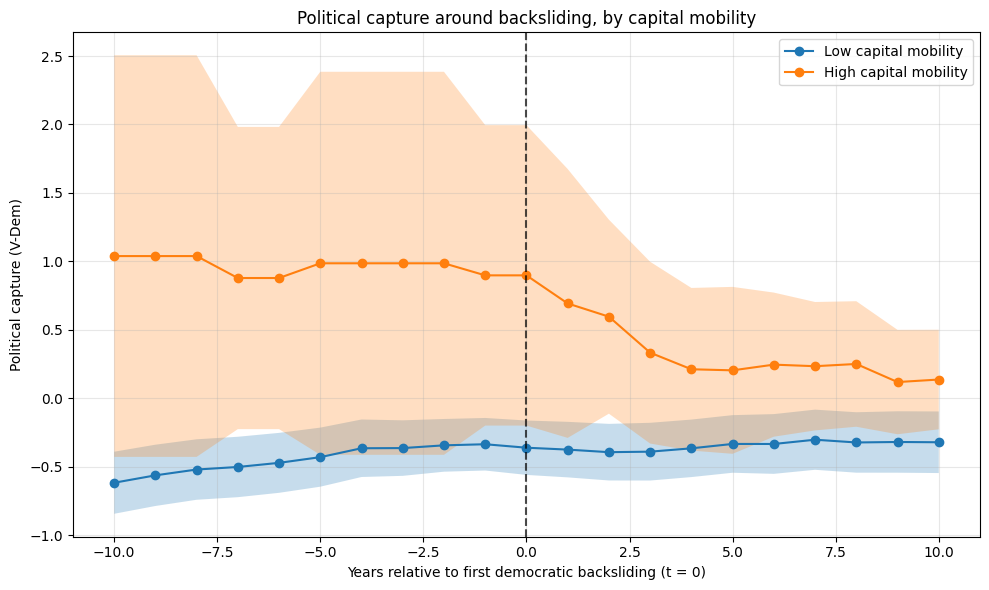

✓ Figure saved: outputs/event_study_capture_by_capmob_ci.png


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

event_capmob_ci = pd.read_csv("outputs/event_study_capture_by_capmob_ci.csv")

plt.figure(figsize=(10, 6))

for label, df_sub in event_capmob_ci.groupby("high_capmob"):
    name = "High capital mobility" if label == 1 else "Low capital mobility"

    plt.plot(
        df_sub["event_time"],
        df_sub["mean_capture"],
        marker="o",
        label=name
    )

    plt.fill_between(
        df_sub["event_time"],
        df_sub["ci_low"],
        df_sub["ci_high"],
        alpha=0.25
    )

plt.axvline(0, linestyle="--", color="black", alpha=0.7)

plt.xlabel("Years relative to first democratic backsliding (t = 0)")
plt.ylabel("Political capture (V-Dem)")
plt.title("Political capture around backsliding, by capital mobility")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    "outputs/event_study_capture_by_capmob_ci.png",
    dpi=300
)
plt.show()

print("✓ Figure saved: outputs/event_study_capture_by_capmob_ci.png")


### Integration of Institutional Capture Indicators

Institutional capture indicators were incorporated into the analytical dataset by merging the V-Dem political capture variable (v2capolit) at the country–year level. A left join was used to preserve the existing analytical sample and avoid unintentionally dropping observations due to incomplete coverage in the source dataset.

The merge relied on consistent country identifiers and temporal alignment to ensure that institutional measures corresponded precisely to the relevant observation year. Post-merge diagnostics were conducted to verify successful integration and to quantify remaining missingness. This step ensured transparency around data availability and informed subsequent decisions regarding indicator inclusion and lag construction.

By explicitly validating coverage after integration, the data preparation process prioritised comparability and reduced the risk of bias introduced through silent data loss or implicit imputation.


In [ ]:
###Integration of Institutional Capture Indicators

print("Merging political capture into df_analysis...")

df_analysis = df_analysis.merge(
    vdem_full[["country_text_id", "year", "v2capolit"]],
    on=["country_text_id", "year"],
    how="left"
)

print("✓ Capture merged into df_analysis")
print("Non-missing v2capolit:", df_analysis["v2capolit"].notna().sum())


Merging political capture into df_analysis...
✓ Capture merged into df_analysis
Non-missing v2capolit: 19052


### Lag Construction and Temporal Ordering

To ensure correct temporal ordering and reduce simultaneity bias, all institutional and economic predictors were lagged by one year at the country level. The panel was explicitly sorted by country and year prior to lag construction to preserve chronological integrity.

Lagged measures were constructed for institutional capture, resource rents, and capital mobility. This design reflects the theoretical claim that institutional conditions precede, rather than respond to, observed democratic backsliding events. Observations with missing lagged values were excluded to avoid reliance on implicit imputation and to maintain transparency around data availability.

This step defines the effective regression sample used in subsequent models and ensures that estimated relationships reflect temporally ordered institutional dynamics rather than contemporaneous correlations.


In [ ]:
###Lag Construction and Temporal Ordering

import statsmodels.api as sm

print("Preparing regression dataset with capture, rents, and capital mobility...")

df_reg = (
    df_analysis
    .sort_values(["country_text_id", "year"])
    .copy()
)

df_reg["capture_lag1"] = (
    df_reg
    .groupby("country_text_id")["v2capolit"]
    .shift(1)
)

df_reg["rents_lag1"] = (
    df_reg
    .groupby("country_text_id")["resource_rents"]
    .shift(1)
)

df_reg["capmob_lag1"] = (
    df_reg
    .groupby("country_text_id")["kaopen"]
    .shift(1)
)

df_reg = df_reg.dropna(
    subset=[
        "backslide",
        "capture_lag1",
        "rents_lag1",
        "capmob_lag1"
    ]
)

print("✓ Regression sample size:", df_reg.shape[0])


### Model Specification and Estimation

Democratic backsliding is modelled as a binary outcome using logistic regression. The specification includes lagged measures of institutional capture, resource rents, and capital mobility, alongside an intercept term. This design reflects the theoretical expectation that institutional conditions precede observable democratic decline.

Models are estimated via maximum likelihood, with standard errors clustered at the country level to account for within-country dependence across time. This approach mitigates the risk of underestimated uncertainty arising from repeated observations within the same political units.

The model prioritises interpretability and theoretical coherence over predictive optimisation, providing a transparent basis for assessing the institutional mechanisms associated with democratic backsliding.


In [ ]:
##Model Specification and Estimation


X = df_reg[["capture_lag1", "rents_lag1", "capmob_lag1"]]
X = sm.add_constant(X)

y = df_reg["backslide"]

model = sm.Logit(y, X).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_reg["country_text_id"]},
    disp=False
)

print(model.summary())


                           Logit Regression Results                           
Dep. Variable:              backslide   No. Observations:                 4875
Model:                          Logit   Df Residuals:                     4871
Method:                           MLE   Df Model:                            3
Date:                Fri, 02 Jan 2026   Pseudo R-squ.:                 0.01497
Time:                        23:12:45   Log-Likelihood:                -1977.4
converged:                       True   LL-Null:                       -2007.5
Covariance Type:              cluster   LLR p-value:                 5.584e-13
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.8904      0.102    -18.575      0.000      -2.090      -1.691
capture_lag1     0.2833      0.073      3.881      0.000       0.140       0.426
rents_lag1      -0.0105      0.007     -1.52

### Model Specification and Estimation - Logit Regression Results

Democratic backsliding is modelled as a binary outcome using logistic regression. The specification includes lagged measures of institutional capture, resource rents, and capital mobility, alongside an intercept term. This design reflects the theoretical expectation that institutional conditions precede observable democratic decline.

Models are estimated via maximum likelihood, with standard errors clustered at the country level to account for within-country dependence across time. This approach mitigates the risk of underestimated uncertainty arising from repeated observations within the same political units.

The model prioritises interpretability and theoretical coherence over predictive optimisation, providing a transparent basis for assessing the institutional mechanisms associated with democratic backsliding.


### Export of Model Results

Regression coefficients and associated statistics were extracted and saved as a standalone output file. This supports transparency, reproducibility, and reuse of results in downstream reporting and portfolio artefacts without requiring re-estimation of the model.


In [ ]:
##### Export of Model Results

results_df = model.summary2().tables[1]

results_df.to_csv(
    "outputs/regression_backslide_capture_rents_capmob.csv"
)

print("✓ Regression results saved")


✓ Regression results saved


### Conditional Predictions for Interpretation

To aid substantive interpretation of the regression results, a grid of counterfactual scenarios was constructed to estimate predicted probabilities of democratic backsliding across the observed range of institutional capture. Capture values were varied between the 5th and 95th percentiles to avoid extrapolation beyond the support of the data.

Resource rents were held constant at their median value to isolate institutional dynamics. Capital mobility was varied between low and high values (25th and 75th percentiles) as a theory-driven conditioning variable rather than a primary explanatory factor.

This approach translates regression coefficients into interpretable quantities and allows visual comparison of how institutional capture relates to backsliding risk under differing levels of capital mobility, without re-estimating the underlying model.


In [ ]:
###Conditional Predictions for Interpretation

import numpy as np
import pandas as pd

# Grid of capture values
capture_vals = np.linspace(
    df_reg["capture_lag1"].quantile(0.05),
    df_reg["capture_lag1"].quantile(0.95),
    50
)

# Hold rents at median (triangulation, not focus)
median_rents = df_reg["rents_lag1"].median()

# Two scenarios: low vs high capital mobility
pred_df = pd.DataFrame({
    "capture_lag1": np.tile(capture_vals, 2),
    "rents_lag1": median_rents,
    "capmob_lag1": np.repeat(
        [df_reg["capmob_lag1"].quantile(0.25),
         df_reg["capmob_lag1"].quantile(0.75)],
        len(capture_vals)
    ),
    "capmob_group": ["Low capital mobility"] * len(capture_vals)
                    + ["High capital mobility"] * len(capture_vals)
})

# Add constant
pred_df["const"] = 1


### Predicted Probabilities of Democratic Backsliding

The fitted logistic regression model was used to generate predicted probabilities of democratic backsliding for each counterfactual scenario. Predictions were computed using the estimated coefficients, holding resource rents constant and varying institutional capture across its observed range under low and high capital mobility conditions.



In [ ]:
###Predicted Probabilities of Democratic Backsliding

# Use the fitted model to predict
pred_df["predicted_prob"] = model.predict(
    pred_df[["const", "capture_lag1", "rents_lag1", "capmob_lag1"]]
)

pred_df.head()


### Predicted Backsliding Risk under Institutional Capture and Capital Mobility

To aid interpretation of the regression results, predicted probabilities of democratic backsliding were generated from the fitted logistic model. Institutional capture was varied across its observed range (5th to 95th percentiles), while resource rents were held constant at their median value.

Capital mobility was treated as a conditioning context rather than a primary explanatory factor, with predictions computed separately for low and high levels of capital openness. This scenario-based approach illustrates how the risk of democratic backsliding increases as institutional capture intensifies, and how this relationship differs under varying macro-level financial conditions.

Presenting results in probability terms facilitates substantive interpretation and supports comparison of institutional dynamics across alternative structural environments.


In [ ]:
import numpy as np
import pandas as pd

# Sanity check
print("Columns in df_reg:", df_reg.columns.tolist())

# Create capture grid
capture_vals = np.linspace(
    df_reg["capture_lag1"].quantile(0.05),
    df_reg["capture_lag1"].quantile(0.95),
    50
)

median_rents = df_reg["rents_lag1"].median()

pred_df = pd.DataFrame({
    "capture_lag1": np.tile(capture_vals, 2),
    "rents_lag1": median_rents,
    "capmob_lag1": np.repeat(
        [
            df_reg["capmob_lag1"].quantile(0.25),
            df_reg["capmob_lag1"].quantile(0.75)
        ],
        len(capture_vals)
    ),
    "capmob_group": (
        ["Low capital mobility"] * len(capture_vals)
        + ["High capital mobility"] * len(capture_vals)
    )
})

# Add constant explicitly
pred_df["const"] = 1

print("✓ Prediction grid created")
pred_df.head()


Columns in df_reg: ['country_name', 'country_text_id', 'year', 'v2x_polyarchy', 'delta_polyarchy', 'backslide', 'control_of_corruption', 'rule_of_law', 'voice_accountability', 'government_effectiveness', 'regulatory_quality', 'control_of_corruption_lag1', 'rule_of_law_lag1', 'voice_accountability_lag1', 'government_effectiveness_lag1', 'regulatory_quality_lag1', 'ever_backslide', 'resource_rents', 'high_rent', 'control_of_corruption_lag1_rev', 'rule_of_law_lag1_rev', 'voice_accountability_lag1_rev', 'government_effectiveness_lag1_rev', 'regulatory_quality_lag1_rev', 'control_of_corruption_lag1_rev_z', 'rule_of_law_lag1_rev_z', 'voice_accountability_lag1_rev_z', 'government_effectiveness_lag1_rev_z', 'regulatory_quality_lag1_rev_z', 'rent_protection_index', 'control_of_corruption_rev', 'rule_of_law_rev', 'voice_accountability_rev', 'government_effectiveness_rev', 'regulatory_quality_rev', 'v2capolit_x', 'v2capolit_y', 'kaopen', 'high_capmob', 'v2capolit', 'capture_lag1', 'rents_lag1', '

,capture_lag1,rents_lag1,capmob_lag1,capmob_group,const
0,-1.148900,2.958272,-1.241745,Low capital mobility,1
1,-1.084535,2.958272,-1.241745,Low capital mobility,1
2,-1.020169,2.958272,-1.241745,Low capital mobility,1
3,-0.955804,2.958272,-1.241745,Low capital mobility,1
4,-0.891439,2.958272,-1.241745,Low capital mobility,1


In [ ]:
# Predict probabilities using the fitted logit model
pred_df["predicted_prob"] = model.predict(
    pred_df[["const", "capture_lag1", "rents_lag1", "capmob_lag1"]]
)

print("✓ Predictions generated")
print(pred_df[["capture_lag1", "capmob_group", "predicted_prob"]].head())


✓ Predictions generated
   capture_lag1          capmob_group  predicted_prob
0     -1.148900  Low capital mobility        0.108635
1     -1.084535  Low capital mobility        0.110414
2     -1.020169  Low capital mobility        0.112218
3     -0.955804  Low capital mobility        0.114048
4     -0.891439  Low capital mobility        0.115903


###Predicted probability of democratic backsliding across levels of institutional capture, conditional on capital mobility.

Predicted probabilities are generated from a logistic regression model with lagged institutional capture, resource rents, and capital mobility. Capture is varied across its observed range (5th–95th percentiles), with resource rents held constant at their median. Separate lines illustrate low and high capital mobility scenarios (25th and 75th percentiles).

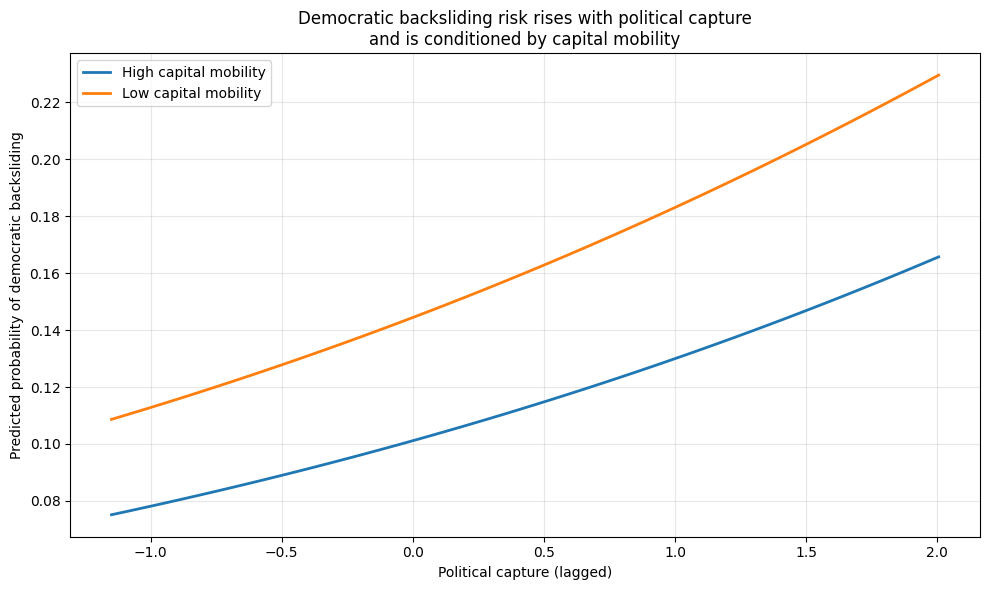

✓ Strong visual saved: outputs/predicted_backsliding_by_capture_capmob.png


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for label, df_sub in pred_df.groupby("capmob_group"):
    plt.plot(
        df_sub["capture_lag1"],
        df_sub["predicted_prob"],
        label=label,
        linewidth=2
    )

plt.xlabel("Political capture (lagged)")
plt.ylabel("Predicted probability of democratic backsliding")
plt.title(
    "Democratic backsliding risk rises with political capture\n"
    "and is conditioned by capital mobility"
)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(
    "outputs/predicted_backsliding_by_capture_capmob.png",
    dpi=300
)
plt.show()

print("✓ Strong visual saved: outputs/predicted_backsliding_by_capture_capmob.png")


###Interpreting the results

Predicted probability of democratic backsliding across levels of political capture, conditional on capital mobility.

Predicted probabilities are generated from a logistic regression model with lagged institutional capture, resource rents, and capital mobility. Political capture is varied across its observed range (5th–95th percentiles), with resource rents held constant at their median. Separate lines represent low and high capital mobility scenarios (25th and 75th percentiles).

### Regime Classification and Threshold Sensitivity

For descriptive purposes, countries were grouped into broad regime categories using average V-Dem polyarchy scores and historical backsliding experience. Initial threshold choices were reviewed after inspection revealed substantively implausible classifications, including contemporary autocracies appearing as precarious democracies.

Thresholds were therefore adjusted to better align with widely accepted regime characterisations, while recognising that V-Dem treats democracy as a continuous concept rather than a categorical one. These regime labels are used solely for contextual interpretation and visualisation and do not affect the regression analyses, which rely on continuous polyarchy measures.

This approach prioritises substantive validity and transparency over mechanical threshold application.


In [ ]:
### Regime Classification and Threshold Sensitivity


# Use polyarchy thresholds (V-Dem standard-ish)
def classify_regime(row):
    if row["mean_polyarchy"] >= 0.7 and row["ever_backslide"] == 0:
        return "Solid democracy"
    elif row["mean_polyarchy"] >= 0.5 and row["ever_backslide"] == 1:
        return "Precarious democracy"
    elif row["mean_polyarchy"] < 0.3:
        return "Autocracy"
    else:
        return "Mixed / transitional"


### Regime Categories for Visualisation - building GIF map

For map-based visualisation, countries were grouped into a simplified set of regime categories to improve interpretability. A single polyarchy threshold was used to distinguish democracies from autocracies, with democratic cases further differentiated based on historical exposure to backsliding.

This simplified classification is intended solely for descriptive visualisation and does not affect the statistical analyses, which rely on continuous institutional measures. The approach prioritises visual clarity while preserving consistency with the broader analytical framework.


In [ ]:
def classify_regime_map(row):
    if row["mean_polyarchy"] >= 0.6:
        if row["ever_backslide"] == 1:
            return "Precarious democracy"
        else:
            return "Solid democracy"
    else:
        return "Autocracy"


In [ ]:
import os
os.makedirs("outputs/gif_frames", exist_ok=True)


In [ ]:
REGIME_COLORS = {
    "Solid democracy": "#1b9e77",
    "Precarious democracy": "#d95f02",
    "Autocracy": "#7570b3"
}




In [ ]:
# Drop pre-existing regime column from Natural Earth
if "regime" in world.columns:
    world = world.drop(columns=["regime"])
    print("✓ Dropped Natural Earth regime column")

# Also drop duplicate columns if any remain
world = world.loc[:, ~world.columns.duplicated()]


✓ Dropped Natural Earth regime column


In [ ]:
YEARS = sorted(df["year"].unique())
print("Animating years:", YEARS[:5], "...", YEARS[-5:])


Animating years: [np.int64(1789), np.int64(1790), np.int64(1791), np.int64(1792), np.int64(1793)] ... [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [ ]:
world = world.rename(columns={"ISO_A3": "country_text_id"})


In [ ]:
df_map = df[["country_text_id", "year", "regime"]].copy()

world_long = world.merge(
    df_map,
    on="country_text_id",
    how="left"
)

print("regime in world_long:", "regime" in world_long.columns)
print("Non-missing regimes:", world_long["regime"].notna().sum())


regime in world_long: True
Non-missing regimes: 86118


In [ ]:
# Keep the V-Dem year and standardize the name
world_long = world_long.rename(columns={"year_y": "year"})

# Drop the map year (not needed)
world_long = world_long.drop(columns=["year_x"], errors="ignore")

print("✓ Year column fixed")
print("Columns now include year:", "year" in world_long.columns)



✓ Year column fixed
Columns now include year: True


In [ ]:
import imageio
import os

YEARS = list(range(1990, 2025))
FRAME_DIR = "outputs/gif_frames"
OUTFILE = "outputs/global_regime_evolution_1990_2024.gif"

frames = []

for year in YEARS:
    frame_path = f"{FRAME_DIR}/regime_{year}.png"
    if os.path.exists(frame_path):
        frames.append(imageio.imread(frame_path))
    else:
        print(f"⚠ Missing frame for {year}, skipping")

print(f"Frames collected: {len(frames)}")

imageio.mimsave(
    OUTFILE,
    frames,
    duration=0.6,   # seconds per frame (adjust if needed)
    loop=0          # loop forever
)

print(f"✓ GIF saved to {OUTFILE}")


/tmp/ipython-input-3313819114.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


Frames collected: 35
✓ GIF saved to outputs/global_regime_evolution_1990_2024.gif


In [ ]:
world_long[
    world_long["country_text_id"] == "USA"
][["ADMIN", "year", "regime"]].head()



,ADMIN,year,regime
421,United States of America,1789.0,Autocracy
422,United States of America,1790.0,Autocracy
423,United States of America,1791.0,Autocracy
424,United States of America,1792.0,Autocracy
425,United States of America,1793.0,Autocracy


In [ ]:
df.groupby(["year", "regime"]).size().unstack(fill_value=0).tail(10)


regime,Autocracy,Precarious democracy,Solid democracy
year,,,
2015,105,72,2
2016,104,73,2
2017,106,72,1
2018,102,76,1
2019,101,77,1
2020,105,73,1
2021,106,72,1
2022,109,69,1
2023,111,67,1


In [ ]:
from matplotlib.patches import Patch

def add_regime_legend(ax):
    legend_elements = [
        Patch(facecolor="#1b9e77", edgecolor="black", label="Solid democracy"),
        Patch(facecolor="#d95f02", edgecolor="black", label="Precarious democracy"),
        Patch(facecolor="#7570b3", edgecolor="black", label="Autocracy"),
    ]
    ax.legend(
        handles=legend_elements,
        loc="lower left",
        title="Regime type",
        frameon=True
    )


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


In [ ]:
REGIME_COLORS = {
    "Solid democracy": "#1b9e77",        # green
    "Precarious democracy": "#d95f02",   # brown/orange
    "Autocracy": "#7570b3"               # purple
}


In [ ]:
def add_regime_legend(ax):
    legend_elements = [
        Patch(facecolor="#1b9e77", edgecolor="black", label="Solid democracy"),
        Patch(facecolor="#d95f02", edgecolor="black", label="Precarious democracy"),
        Patch(facecolor="#7570b3", edgecolor="black", label="Autocracy"),
    ]
    ax.legend(
        handles=legend_elements,
        title="Regime type",
        loc="lower left",
        frameon=True,
        fontsize=12,
        title_fontsize=13
    )


In [ ]:
YEARS = list(range(1990, 2025))
FRAME_DIR = "outputs/gif_frames"

for year in YEARS:
    world_year = world_long[world_long["year"] == year]

    if world_year.empty:
        print(f"⚠ No data for {year}, skipping")
        continue

    fig, ax = plt.subplots(1, 1, figsize=(18, 10))

    world_year.plot(
        color=world_year["regime"].map(REGIME_COLORS).fillna("lightgrey"),
        ax=ax,
        edgecolor="black",
        linewidth=0.2
    )

    add_regime_legend(ax)

    ax.set_title(f"Global regime landscape — {year}", fontsize=20)
    ax.axis("off")

    plt.tight_layout()
    plt.savefig(
        f"{FRAME_DIR}/regime_{year}.png",
        dpi=150
    )
    plt.close()

    print(f"✓ Saved frame for {year}")


✓ Saved frame for 1990
✓ Saved frame for 1991
✓ Saved frame for 1992
✓ Saved frame for 1993
✓ Saved frame for 1994
✓ Saved frame for 1995
✓ Saved frame for 1996
✓ Saved frame for 1997
✓ Saved frame for 1998
✓ Saved frame for 1999
✓ Saved frame for 2000
✓ Saved frame for 2001
✓ Saved frame for 2002
✓ Saved frame for 2003
✓ Saved frame for 2004
✓ Saved frame for 2005
✓ Saved frame for 2006
✓ Saved frame for 2007
✓ Saved frame for 2008
✓ Saved frame for 2009
✓ Saved frame for 2010
✓ Saved frame for 2011
✓ Saved frame for 2012
✓ Saved frame for 2013
✓ Saved frame for 2014
✓ Saved frame for 2015
✓ Saved frame for 2016
✓ Saved frame for 2017
✓ Saved frame for 2018
✓ Saved frame for 2019
✓ Saved frame for 2020
✓ Saved frame for 2021
✓ Saved frame for 2022
✓ Saved frame for 2023
✓ Saved frame for 2024


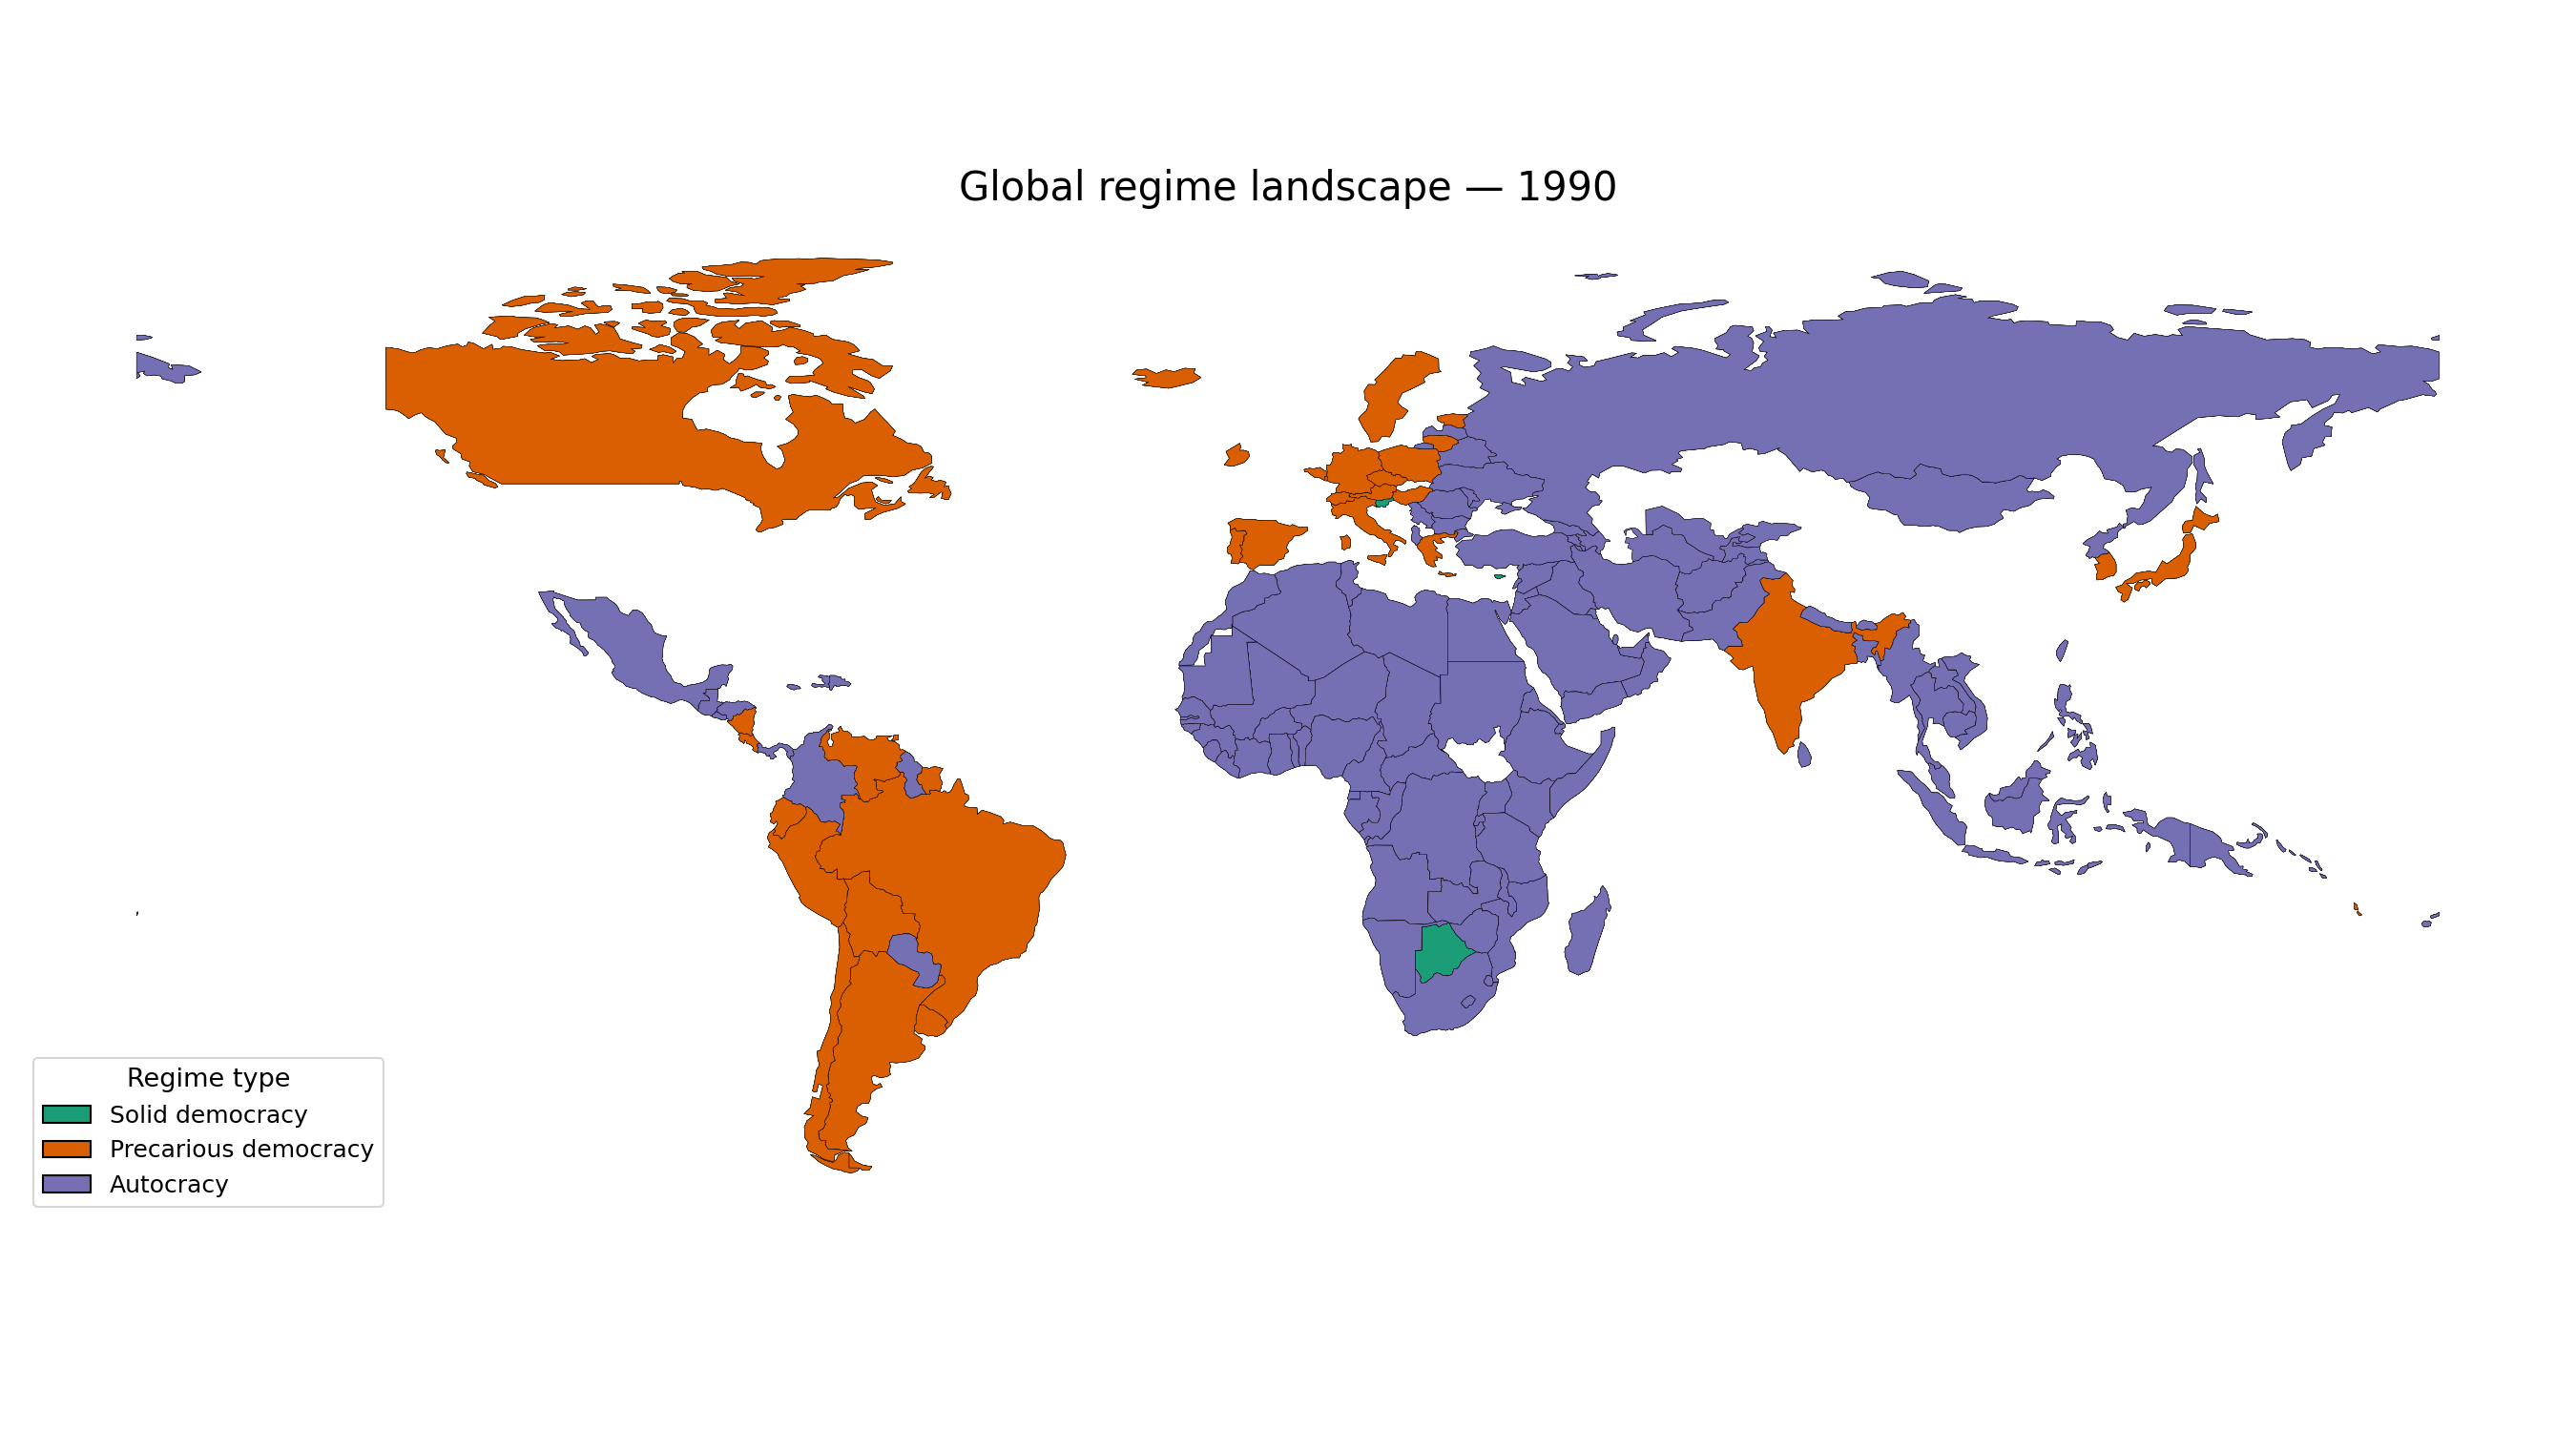

In [ ]:
from PIL import Image
display(Image.open("outputs/gif_frames/regime_1990.png"))


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import imageio
import os


In [ ]:
world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)

print("✓ Loaded canonical Natural Earth Admin-0 countries")


✓ Loaded canonical Natural Earth Admin-0 countries


In [ ]:
world["country_text_id"] = world["ADM0_A3"]

# Drop aggregates / invalid
world = world[~world["country_text_id"].isin(["-99", None])]


In [ ]:
# Remove any leftover regime column from the map
world = world.drop(columns=["regime"], errors="ignore")

world_long = world.merge(
    df[["country_text_id", "year", "regime"]],
    on="country_text_id",
    how="left"
)

# Fix year naming
world_long = (
    world_long
    .rename(columns={"year_y": "year"})
    .drop(columns=["year_x"], errors="ignore")
)

print("✓ world_long built")


✓ world_long built


In [ ]:
world_long[
    world_long["country_text_id"] == "USA"
][["ADMIN", "year", "regime"]].head()


,ADMIN,year,regime
421,United States of America,1789.0,Autocracy
422,United States of America,1790.0,Autocracy
423,United States of America,1791.0,Autocracy
424,United States of America,1792.0,Autocracy
425,United States of America,1793.0,Autocracy


In [ ]:
REGIME_COLORS = {
    "Solid democracy": "#1b9e77",
    "Precarious democracy": "#d95f02",
    "Autocracy": "#7570b3"
}

def add_regime_legend(ax):
    legend_elements = [
        Patch(facecolor="#1b9e77", edgecolor="black", label="Solid democracy"),
        Patch(facecolor="#d95f02", edgecolor="black", label="Precarious democracy"),
        Patch(facecolor="#7570b3", edgecolor="black", label="Autocracy"),
    ]
    ax.legend(
        handles=legend_elements,
        title="Regime type",
        loc="lower left",
        frameon=True,
        fontsize=12,
        title_fontsize=13
    )


In [ ]:
FRAME_DIR = "outputs/gif_frames"
os.makedirs(FRAME_DIR, exist_ok=True)

YEARS = list(range(1990, 2025))

for year in YEARS:
    world_year = world_long[world_long["year"] == year]

    if world_year.empty:
        continue

    fig, ax = plt.subplots(1, 1, figsize=(18, 10))

    world_year.plot(
        color=world_year["regime"].map(REGIME_COLORS).fillna("lightgrey"),
        ax=ax,
        edgecolor="black",
        linewidth=0.2
    )

    add_regime_legend(ax)

    ax.set_title(f"Global regime landscape — {year}", fontsize=20)
    ax.axis("off")

    plt.savefig(
        f"{FRAME_DIR}/regime_{year}.png",
        dpi=150
    )
    plt.close()

    print(f"✓ Saved frame for {year}")


✓ Saved frame for 1990
✓ Saved frame for 1991
✓ Saved frame for 1992
✓ Saved frame for 1993
✓ Saved frame for 1994
✓ Saved frame for 1995
✓ Saved frame for 1996
✓ Saved frame for 1997
✓ Saved frame for 1998
✓ Saved frame for 1999
✓ Saved frame for 2000
✓ Saved frame for 2001
✓ Saved frame for 2002
✓ Saved frame for 2003
✓ Saved frame for 2004
✓ Saved frame for 2005
✓ Saved frame for 2006
✓ Saved frame for 2007
✓ Saved frame for 2008
✓ Saved frame for 2009
✓ Saved frame for 2010
✓ Saved frame for 2011
✓ Saved frame for 2012
✓ Saved frame for 2013
✓ Saved frame for 2014
✓ Saved frame for 2015
✓ Saved frame for 2016
✓ Saved frame for 2017
✓ Saved frame for 2018
✓ Saved frame for 2019
✓ Saved frame for 2020
✓ Saved frame for 2021
✓ Saved frame for 2022
✓ Saved frame for 2023
✓ Saved frame for 2024


In [ ]:
OUTFILE = "outputs/global_regime_evolution_1990_2024.gif"

frames = []
for year in YEARS:
    frame_path = f"{FRAME_DIR}/regime_{year}.png"
    if os.path.exists(frame_path):
        frames.append(imageio.imread(frame_path))

print(f"Frames collected: {len(frames)}")

imageio.mimsave(
    OUTFILE,
    frames,
    duration=0.6,
    loop=0
)

print(f"✓ GIF saved to {OUTFILE}")


/tmp/ipython-input-371483566.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


Frames collected: 35
✓ GIF saved to outputs/global_regime_evolution_1990_2024.gif


###Appendix


In [ ]:
# ============================================================
# FIRST DIFFERENCES
# ============================================================

df = df.sort_values(["country_id", "year"])

df["d_capture"] = df.groupby("country_id")["capture_index_lag1"].diff()
df["d_corruption"] = df.groupby("country_id")["v2x_corr"].diff()
df["d_leginter"] = df.groupby("country_id")["v2xlg_leginter"].diff()


### Supplementary comparison: disaggregated institutional model vs. capture index model

This table compares selected coefficients from the main institutional model (with year fixed effects) to the composite capture index model. The purpose is not to re-interpret individual coefficients, but to illustrate how the joint capture environment relates to the disaggregated institutional mechanisms.

The capture index aggregates multiple institutional dimensions into a single measure of systemic capture, while the institutional model estimates their effects separately. The comparison highlights that democratic backsliding is associated both with specific institutional interventions (e.g. legislative interference, political exclusion) and with broader capture environments in which these mechanisms co-occur.


In [ ]:
# ============================================================
# COMBINED REGRESSION TABLE (MAIN RESULTS)
# ============================================================

import numpy as np

# -----------------------------
# Helper: extract model results
# -----------------------------
def extract_results(res, model_name):
    out = pd.DataFrame({
        f"{model_name} coef": res.params,
        f"{model_name} se": res.bse,
        f"{model_name} p": res.pvalues,
        f"{model_name} OR": np.exp(res.params)
    })
    return out

# Extract results
table_model1 = extract_results(res1, "Institutional model")
table_capture = extract_results(cap_results, "Capture index model")

# Combine tables
results_table = table_model1.join(table_capture, how="outer")

# Keep only substantive rows (drop year FE)
rows_to_keep = [
    "Party System Institutionalization (lagged)",
    "Clientelism (lagged)",
    "Alternative Sources of Information (lagged)",
    "Legislative Interference (lagged)",
    "Executive Control of Election Regulation (lagged)",
    "Political Exclusion (lagged)",
    "Systemic Corruption (lagged)",
    "capture_index_lag1"
]

results_table = results_table.loc[
    results_table.index.isin(rows_to_keep)
]

# Sort for readability
results_table = results_table.sort_index()

print("\nMAIN RESULTS TABLE (coefficients, SEs, p-values, odds ratios):")
display(results_table.round(3))

# Save for paper
results_table.to_csv(
    "/content/main_results_table_model1_vs_capture.csv"
)

print("\nSaved: /content/main_results_table_model1_vs_capture.csv")



MAIN RESULTS TABLE (coefficients, SEs, p-values, odds ratios):


,Institutional model coef,Institutional model se,Institutional model p,Institutional model OR,Capture index model coef,Capture index model se,Capture index model p,Capture index model OR
Alternative Sources of Information (lagged),2.794,0.587,0.000,16.344,NaN,NaN,NaN,NaN
Clientelism (lagged),-1.446,0.589,0.014,0.235,NaN,NaN,NaN,NaN
Executive Control of Election Regulation (lagged),0.471,0.178,0.008,1.601,NaN,NaN,NaN,NaN
Legislative Interference (lagged),2.381,0.405,0.000,10.813,NaN,NaN,NaN,NaN
Party System Institutionalization (lagged),-1.179,0.525,0.025,0.308,NaN,NaN,NaN,NaN
Political Exclusion (lagged),1.428,0.494,0.004,4.171,NaN,NaN,NaN,NaN
Systemic Corruption (lagged),1.224,0.552,0.027,3.402,NaN,NaN,NaN,NaN
capture_index_lag1,NaN,NaN,NaN,NaN,0.83,0.171,0.0,2.292



Saved: /content/main_results_table_model1_vs_capture.csv


In [ ]:
# ============================================================
# COLOR-BLIND SAFE MULTI-INDICATOR COUNTRY PLOT
# ============================================================

import matplotlib.pyplot as plt

COLOR_OKABE_ITO = {
    "capture": "#0072B2",        # blue
    "leginter": "#E69F00",       # orange
    "corruption": "#009E73",     # bluish green
    "event": "#000000"           # black
}

def plot_country_trajectory(country_id, country_name):
    cdf = df[df["country_id"] == country_id].sort_values("year")

    fig, ax1 = plt.subplots(figsize=(10, 4))

    # --- Capture index (main axis)
    ax1.plot(
        cdf["year"],
        cdf["capture_index_lag1"].shift(-1),
        color=COLOR_OKABE_ITO["capture"],
        linewidth=2.8,
        label="Capture index"
    )
    ax1.set_ylabel("Capture index (standardized)")
    ax1.set_xlabel("Year")

    # --- Secondary axis: institutional components
    ax2 = ax1.twinx()

    ax2.plot(
        cdf["year"],
        cdf["v2xlg_leginter"],
        color=COLOR_OKABE_ITO["leginter"],
        linestyle="--",
        linewidth=2,
        label="Legislative interference"
    )

    ax2.plot(
        cdf["year"],
        cdf["v2x_corr"],
        color=COLOR_OKABE_ITO["corruption"],
        linestyle=":",
        linewidth=2,
        label="Systemic corruption"
    )

    ax2.set_ylabel("V-Dem scale")

    # --- Backsliding events (vertical lines)
    for y in cdf.loc[cdf["backsliding"] == 1, "year"]:
        ax1.axvline(
            y,
            color=COLOR_OKABE_ITO["event"],
            alpha=0.25,
            linewidth=1.5
        )

    # --- Legend (combined)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2,
        labels1 + labels2,
        loc="upper left",
        frameon=False
    )

    ax1.set_title(country_name)
    ax1.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


### Appendix Figure: Regime-level descriptive trajectories

This figure presents regime-level averages of institutional capture, corruption,
legislative interference, and democratic backsliding over time. Values are aggregated
by regime type and year and smoothed using a five-year rolling mean.

The figure is descriptive and intended to illustrate broad differences across regime
types. It does not account for country-specific dynamics, time-invariant heterogeneity,
or global shocks. All inferential claims in the paper rely on the regression models
reported in the main text.


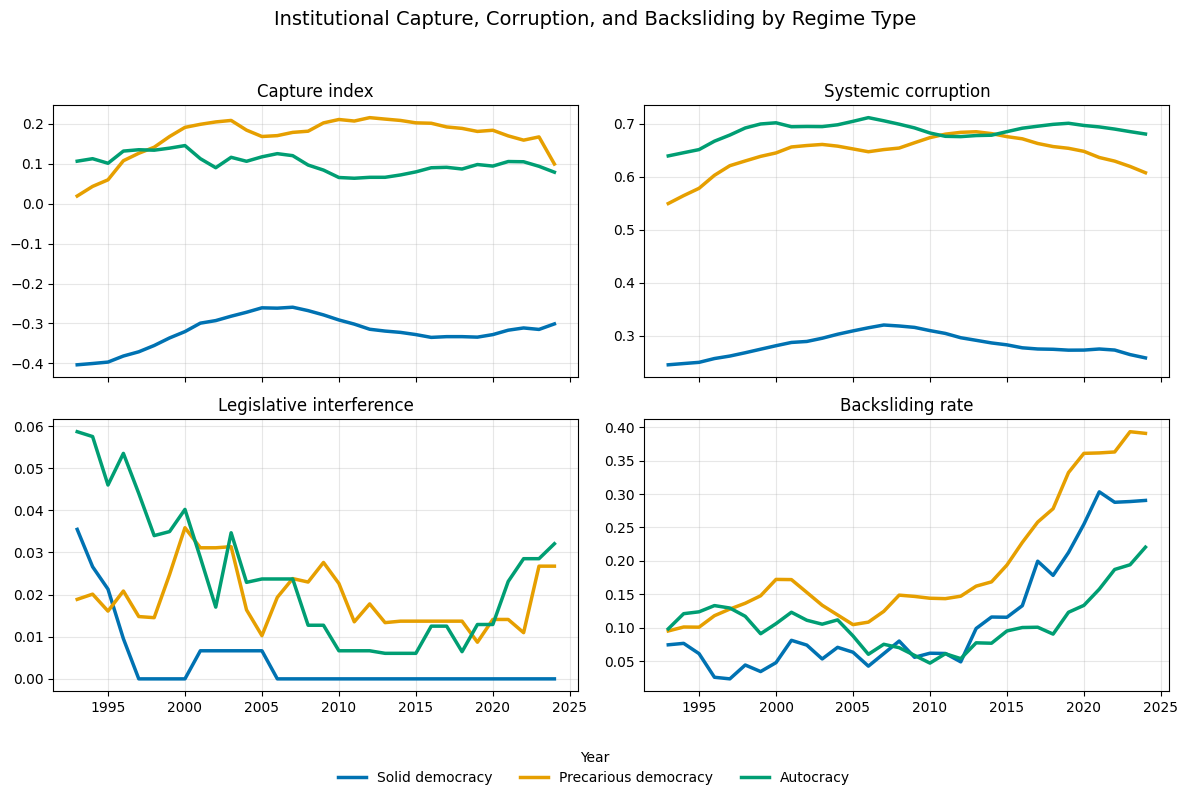

In [ ]:
# ============================================================
# AGGREGATED REGIME-LEVEL TRAJECTORIES
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# STEP 1: Prepare plotting dataset
# ------------------------------------------------------------
plot_vars = [
    "capture_index_lag1",
    "v2x_corr",
    "v2xlg_leginter",
    "backsliding"
]

plot_df = (
    df
    .dropna(subset=plot_vars + ["regime_type"])
    .copy()
)

# Align capture index to time t for visualization
plot_df["capture_index_vis"] = plot_df["capture_index_lag1"].shift(-1)

# ------------------------------------------------------------
# STEP 2: Aggregate by regime-year
# ------------------------------------------------------------
agg_df = (
    plot_df
    .groupby(["regime_type", "year"])
    .agg(
        capture_index=("capture_index_vis", "mean"),
        corruption=("v2x_corr", "mean"),
        legislative_interference=("v2xlg_leginter", "mean"),
        backsliding_rate=("backsliding", "mean"),
        n_countries=("country_id", "nunique")
    )
    .reset_index()
)

# ------------------------------------------------------------
# STEP 3: Smooth trajectories (5-year rolling mean)
# ------------------------------------------------------------
agg_df = agg_df.sort_values(["regime_type", "year"])

for var in [
    "capture_index",
    "corruption",
    "legislative_interference",
    "backsliding_rate"
]:
    agg_df[f"{var}_smoothed"] = (
        agg_df
        .groupby("regime_type")[var]
        .transform(lambda x: x.rolling(5, min_periods=3).mean())
    )

# ------------------------------------------------------------
# STEP 4: Color-blind–safe palette (Okabe–Ito)
# ------------------------------------------------------------
COLORS = {
    "Solid democracy": "#0072B2",        # blue
    "Precarious democracy": "#E69F00",   # orange
    "Autocracy": "#009E73"               # green
}

# ------------------------------------------------------------
# STEP 5: Plot aggregated trajectories
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

panels = [
    ("capture_index_smoothed", "Capture index"),
    ("corruption_smoothed", "Systemic corruption"),
    ("legislative_interference_smoothed", "Legislative interference"),
    ("backsliding_rate_smoothed", "Backsliding rate")
]

for ax, (var, title) in zip(axes.flatten(), panels):
    for regime, color in COLORS.items():
        sub = agg_df[agg_df["regime_type"] == regime]

        ax.plot(
            sub["year"],
            sub[var],
            label=regime,
            color=color,
            linewidth=2.5
        )

    ax.set_title(title)
    ax.grid(alpha=0.3)

# Shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=3,
    frameon=False
)

fig.suptitle(
    "Institutional Capture, Corruption, and Backsliding by Regime Type",
    fontsize=14
)

fig.text(0.5, 0.04, "Year", ha="center")
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


### Robustness Check: Electoral Management Body Capture

This code block constructs a one-year lag of the Electoral Management Body (EMB) capture indicator and defines a restricted estimation sample in which both political system capture and EMB capture are jointly observed. Observations with missing values in either lagged capture measure or the democratic backsliding outcome are removed to ensure a valid robustness sample.

The resulting dataset is smaller than the main estimation sample, reflecting more limited data availability for EMB capture. The number of countries retained is printed to document this reduction in coverage.

This step is used to assess whether the association between institutional capture and democratic backsliding extends beyond political system capture alone. Results based on this restricted sample are treated as robustness checks rather than primary findings, due to reduced country and temporal coverage.


In [ ]:
### Robustness Check: Electoral Management Body Capture


df["v2elembcap_lag1"] = df.groupby("country_id")["v2elembcap"].shift(1)

robust_df = df.dropna(
    subset=["v2capolit_lag1", "v2elembcap_lag1", "backsliding"]
)

print("Countries (robustness):", robust_df["country_name"].nunique())


Countries (robustness): 108


### Appendix: Two-Panel Coefficient Plot (Year Fixed Effects)

This code generates a supplementary two-panel coefficient plot separating the substantive political capture effect from year fixed effects. The figure is included for transparency regarding model structure and fixed-effects implementation. Substantive interpretation focuses on the political capture coefficient and predicted probabilities shown in the main body.


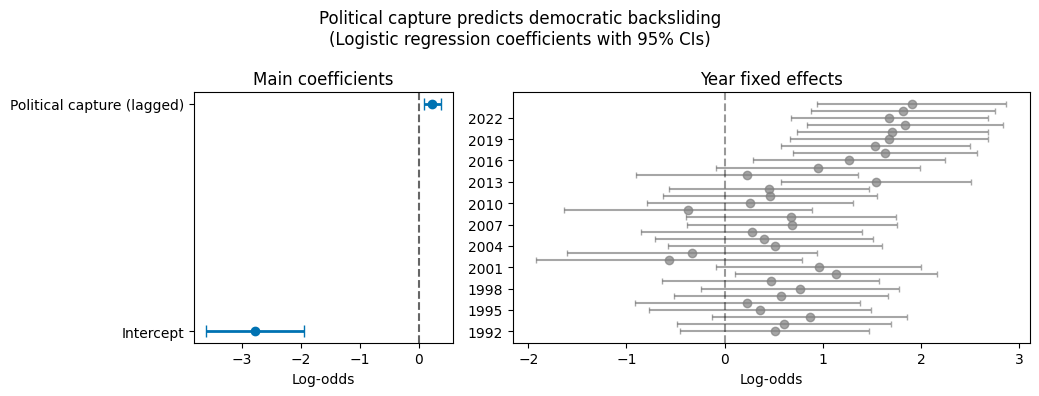

In [ ]:
# ============================================================
# TWO-PANEL COEFFICIENT PLOT
# Main effect + Year fixed effects
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# STEP 1: Build coefficient dataframe
# ------------------------------------------------------------
params = results.params
conf = results.conf_int()
conf.columns = ["ci_low", "ci_high"]

coef_df = (
    pd.concat([params, conf], axis=1)
    .reset_index()
    .rename(columns={"index": "variable", 0: "coef"})
)

# Identify year FE vs substantive
coef_df["type"] = np.where(
    coef_df["variable"].str.isnumeric(),
    "Year FE",
    "Substantive"
)

# ------------------------------------------------------------
# STEP 2: Split panels
# ------------------------------------------------------------
main_df = coef_df[coef_df["variable"].isin(["v2capolit_lag1", "const"])].copy()
year_df = coef_df[coef_df["type"] == "Year FE"].copy()

# Sort year effects by year
year_df["year"] = year_df["variable"].astype(int)
year_df = year_df.sort_values("year")

# ------------------------------------------------------------
# STEP 3: Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(
    1, 2,
    figsize=(10.5, 4),
    gridspec_kw={"width_ratios": [1, 2]},
    sharex=False
)

# ========== PANEL A: MAIN EFFECT ==========
ax = axes[0]

labels = {
    "v2capolit_lag1": "Political capture (lagged)",
    "const": "Intercept"
}

y_pos = np.arange(len(main_df))

ax.errorbar(
    main_df["coef"],
    y_pos,
    xerr=[
        main_df["coef"] - main_df["ci_low"],
        main_df["ci_high"] - main_df["coef"]
    ],
    fmt="o",
    color="#0072B2",
    elinewidth=2,
    capsize=4
)

ax.axvline(0, color="black", linestyle="--", alpha=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(main_df["variable"].map(labels))
ax.set_xlabel("Log-odds")
ax.set_title("Main coefficients")

# ========== PANEL B: YEAR FIXED EFFECTS ==========
ax = axes[1]

y_pos = np.arange(len(year_df))

ax.errorbar(
    year_df["coef"],
    y_pos,
    xerr=[
        year_df["coef"] - year_df["ci_low"],
        year_df["ci_high"] - year_df["coef"]
    ],
    fmt="o",
    color="gray",
    alpha=0.7,
    elinewidth=1.5,
    capsize=2
)

ax.axvline(0, color="black", linestyle="--", alpha=0.4)

# Show every 3rd year label to avoid clutter
tick_idx = np.arange(0, len(year_df), 3)
ax.set_yticks(tick_idx)
ax.set_yticklabels(year_df.iloc[tick_idx]["year"])

ax.set_xlabel("Log-odds")
ax.set_title("Year fixed effects")

plt.suptitle(
    "Political capture predicts democratic backsliding\n(Logistic regression coefficients with 95% CIs)",
    fontsize=12
)

plt.tight_layout()
plt.show()


### Event-Study Capture Trajectories by Resource-Rent Dependence

This code block extends the event-study analysis by conditioning political capture trajectories on countries’ exposure to natural resource rents. Within a ten-year window around the onset of democratic backsliding, mean levels of political capture are computed separately for high-rent and low-rent country–years.

Countries are classified based on whether resource rents exceed the sample median in a given year. The resulting aggregation allows differences in the timing and level of institutional capture to be compared across rent-dependent and non–rent-dependent contexts.

The aggregated event-study series is exported to a CSV file to support rent-stratified figures and to preserve the underlying values used in supplementary analyses.


In [ ]:
WINDOW = 10

event_rent = (
    df_ev[df_ev["event_time"].between(-WINDOW, WINDOW)]
    .groupby(["event_time", "high_rent"])["v2capolit"]
    .mean()
    .reset_index()
)

event_rent.to_csv("outputs/event_study_capture_by_rent.csv", index=False)
print("✓ Saved: outputs/event_study_capture_by_rent.csv")
event_rent.head()


✓ Saved: outputs/event_study_capture_by_rent.csv


,event_time,high_rent,v2capolit
0,-10.0,0,-0.574061
1,-10.0,1,-0.045500
2,-9.0,0,-0.567080
3,-9.0,1,0.785000
4,-8.0,0,-0.517408


### Confidence Intervals for Rent-Stratified Event-Study Trajectories

This code block computes point estimates and uncertainty bounds for the event-aligned trajectories of political system capture, separately for high–resource-rent and low–resource-rent country–years. Within a ten-year window around the onset of democratic backsliding, the mean, standard deviation, and sample size of the political capture indicator are calculated for each relative event year and rent category.

Standard errors and 95 percent confidence intervals are derived under a normal approximation. The resulting estimates allow uncertainty to be displayed transparently in rent-stratified event-study figures and provide context for differences in capture dynamics across resource environments.

The aggregated results are exported to a CSV file to preserve the underlying values used in supplementary figures and to ensure reproducibility without requiring the notebook to be rerun.


In [ ]:
####Confidence Intervals for Rent-Stratified Event-Study Trajectories

import numpy as np

WINDOW = 10

event_rent_ci = (
    df_ev[df_ev["event_time"].between(-WINDOW, WINDOW)]
    .groupby(["event_time", "high_rent"])
    .agg(
        mean_capture=("v2capolit", "mean"),
        n=("v2capolit", "count"),
        sd=("v2capolit", "std")
    )
    .reset_index()
)

event_rent_ci["se"] = event_rent_ci["sd"] / np.sqrt(event_rent_ci["n"])
event_rent_ci["ci_low"] = event_rent_ci["mean_capture"] - 1.96 * event_rent_ci["se"]
event_rent_ci["ci_high"] = event_rent_ci["mean_capture"] + 1.96 * event_rent_ci["se"]

event_rent_ci.to_csv(
    "outputs/event_study_capture_by_rent_ci.csv",
    index=False
)

print("✓ Saved: outputs/event_study_capture_by_rent_ci.csv")
event_rent_ci.head()



✓ Saved: outputs/event_study_capture_by_rent_ci.csv


,event_time,high_rent,mean_capture,n,sd,se,ci_low,ci_high
0,-10.0,0,-0.574061,99,1.208871,0.121496,-0.812193,-0.335928
1,-10.0,1,-0.045500,4,0.983237,0.491619,-1.009072,0.918072
2,-9.0,0,-0.567080,100,1.168670,0.116867,-0.796139,-0.338021
3,-9.0,1,0.785000,5,1.060462,0.474253,-0.144536,1.714536
4,-8.0,0,-0.517408,103,1.160770,0.114374,-0.741581,-0.293235


### Political Capture Around Backsliding, by Resource Rents (with Confidence Intervals)

This figure presents event-aligned trajectories of political system capture around the onset of democratic backsliding, separately for country–years with high and low levels of natural resource rents. The solid lines report mean levels of the V-Dem political capture indicator, while the shaded areas represent 95 percent confidence intervals derived from within-group variation.

The figure shows that political capture is substantially higher and rises earlier in high-rent contexts prior to democratic backsliding, whereas capture levels in low-rent contexts are lower and increase more gradually. Following the onset of backsliding, capture remains elevated in both groups, with greater volatility observed among high-rent cases.

The wide confidence intervals in early pre-event years for high-rent countries reflect small sample sizes and underscore that this analysis is descriptive. The figure is included to illustrate heterogeneity in capture dynamics rather than to establish causal moderation effects.


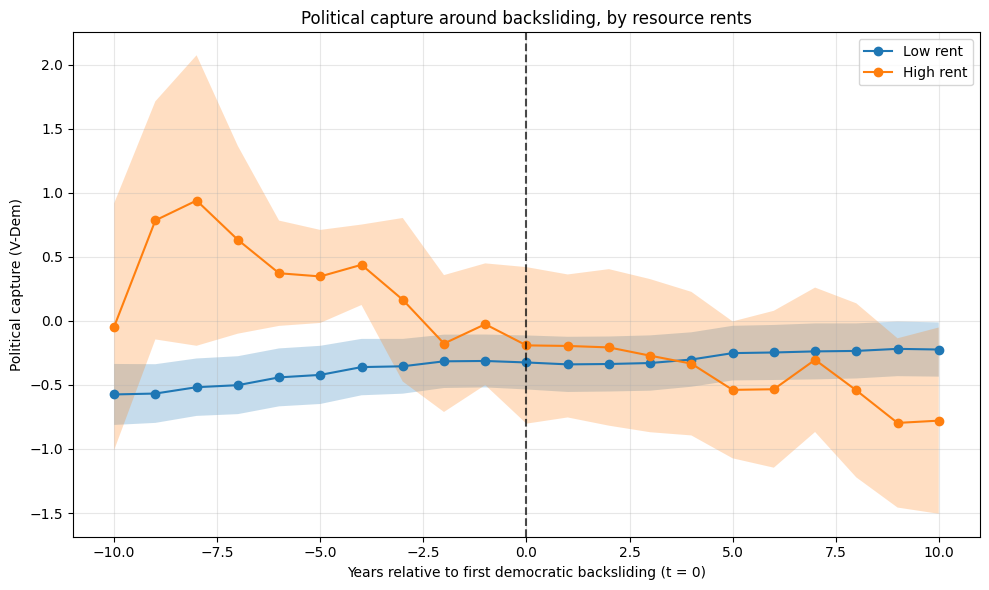

✓ Figure saved: outputs/event_study_capture_by_rent_ci.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

event_rent_ci = pd.read_csv("outputs/event_study_capture_by_rent_ci.csv")

plt.figure(figsize=(10, 6))

for label, df_sub in event_rent_ci.groupby("high_rent"):
    name = "High rent" if label == 1 else "Low rent"

    plt.plot(
        df_sub["event_time"],
        df_sub["mean_capture"],
        marker="o",
        label=name
    )

    plt.fill_between(
        df_sub["event_time"],
        df_sub["ci_low"],
        df_sub["ci_high"],
        alpha=0.25
    )

plt.axvline(0, linestyle="--", color="black", alpha=0.7)

plt.xlabel("Years relative to first democratic backsliding (t = 0)")
plt.ylabel("Political capture (V-Dem)")
plt.title("Political capture around backsliding, by resource rents")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    "outputs/event_study_capture_by_rent_ci.png",
    dpi=300
)
plt.show()

print("✓ Figure saved: outputs/event_study_capture_by_rent_ci.png")


### Analytical Dataset Checkpointing

Following integration and validation of institutional capture indicators, the analytical dataset was saved as a standalone artefact. This checkpoint supports reproducibility, enables downstream modelling without repeated data preparation, and provides a stable reference for sensitivity checks and future iterations of the analysis.


In [ ]:
Analytical Dataset Checkpointing
df_analysis.to_csv(
    "outputs/df_analysis_with_capture.csv",
    index=False
)

print("✓ Saved: outputs/df_analysis_with_capture.csv")


✓ Saved: outputs/df_analysis_with_capture.csv


### Descriptive Regime Classification

For descriptive and illustrative purposes, countries were grouped into broad regime categories based on average V-Dem polyarchy scores and historical exposure to democratic backsliding. These categories are intended to aid interpretation and contextualisation rather than to serve as analytical inputs.

All statistical models rely on continuous institutional indicators rather than categorical regime labels. This approach avoids sensitivity to arbitrary threshold choices while preserving the substantive richness of the underlying measures.


In [ ]:
### Descriptive Regime Classification


def classify_regime(row):
    if row["mean_polyarchy"] >= 0.7 and row["ever_backslide"] == 0:
        return "Solid democracy"
    elif row["mean_polyarchy"] >= 0.5 and row["ever_backslide"] == 1:
        return "Precarious democracy"
    elif row["mean_polyarchy"] < 0.3:
        return "Autocracy"
    else:
        return "Mixed / transitional"

regime_decade["regime"] = regime_decade.apply(classify_regime, axis=1)


### Time-Varying Regime Classification

To support descriptive analysis of regime trajectories, a time-varying regime label was constructed at the country–year level. Democracies were identified using contemporaneous polyarchy scores, while democratic cases were further distinguished based on whether a backsliding event had already occurred by a given year.

This classification allows countries to transition from solid to precarious democracies over time and is used solely for contextual interpretation and visualisation. All statistical analyses rely on continuous institutional measures and event-based outcomes, avoiding dependence on categorical regime thresholds.


In [ ]:
### Time-Varying Regime Classification

# Merge first backslide year if not already merged
df = df.merge(
    first_backslide,
    on="country_text_id",
    how="left"
)

def classify_regime_year(row):
    if row["v2x_polyarchy"] >= 0.6:
        if (
            pd.notna(row["first_backslide_year"])
            and row["first_backslide_year"] <= row["year"]
        ):
            return "Precarious democracy"
        else:
            return "Solid democracy"
    else:
        return "Autocracy"

df["regime"] = df.apply(classify_regime_year, axis=1)
